# Seasonal cycle

Assessment of model seasonal cycle.

The assessment involves calculating the monthly climatology at each grid point and then summing the absolute value of the difference between the bias corrected model data and observations acorss all twelve months. That sum represents the seasonal cycle bias. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import calendar

import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

import utils

In [2]:
# variable-specific settings
variable = 'pr'
name = 'precipitation'
units = 'mm'
bias_levels = np.arange(0, 450, 50)
frac_levels = np.arange(0, 1.5, 0.15)

In [3]:
def monthly_climatology(da, var):
    """Calculate the monthly rainfall climatology"""
    
    if var == 'pr':
        da_monthly = da.resample(time='1M').sum('time')
        monthly_means = da_monthly.groupby('time.month').mean('time')
    else:
        monthly_means = da.groupby('time.month').mean('time')
    monthly_means = monthly_means.compute()
    
    return monthly_means

In [4]:
def get_assessment_time_bounds(gcm, task):
    """Get assessment time bounds for given GCM/task combination"""

    if gcm == 'ECMWF-ERA5':
        start_date = '2000-01-01' if task == 'xvalidation' else '1980-01-01'
    else:
        start_date = '1990-01-01' if task == 'xvalidation' else '1980-01-01' 
    end_date = '2019-12-31'
    
    return start_date, end_date


def get_training_time_bounds(gcm):
    """Get xvalidation training time bounds for given GCM/task combination"""

    if gcm == 'ECMWF-ERA5':
        start_date = '1980-01-01'
        end_date = '1999-12-31'
    else:
        start_date = '1960-01-01' 
        end_date = '1989-12-31'
    
    return start_date, end_date


def get_obs_data(var, start_date, end_date):
    """Get obs data"""
    
    da_obs = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        start_date,
        end_date,
    )
    
    return monthly_climatology(da_obs, var)


def get_gcm_data(var, gcm, start_date, end_date):
    """Get reference/raw GCM data."""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']

    da_gcm = utils.get_npcp_data(
        var,
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date,
        end_date,
    )

    return monthly_climatology(da_gcm, var)
    

def get_rcm_data(var, gcm, rcm, start_date, end_date):
    """Get reference/raw RCM data"""
    
    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    
    da_rcm = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date,
        end_date,
    )
    
    return monthly_climatology(da_rcm, var)


def get_bias_corrected_rcm_data(var, gcm, rcm, task, start_date, end_date):
    """Get bias corrected RCM data"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']
    
    da_dict = {}
    
    da_ecdfm = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
    )
    da_dict['ecdfm'] = monthly_climatology(da_ecdfm, var)
    
    da_qme = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'qme',
        f'task-{task}',
        start_date,
        end_date,
    )
    da_dict['qme'] = monthly_climatology(da_qme, var)
    
    if task == 'xvalidation':
        da_qdm = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
        )
        da_dict['qdm'] = monthly_climatology(da_qdm, var)
        
    # TODO: Add additional bias correction methods as data becomes available 

    return da_dict


def get_bias_corrected_gcm_data(var, gcm, task, start_date, end_date):
    """Get bias corrected GCM data"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']
    assert task in ['historical', 'xvalidation']
    
    da_dict = {}
    
    da_ecdfm = utils.get_npcp_data(
        var,
        gcm,
        'GCM',
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
    )
    da_dict['ecdfm'] = monthly_climatology(da_ecdfm, var)
        
    if task == 'xvalidation':
        da_qdm = utils.get_npcp_data(
            var,
            gcm,
            'GCM',
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
        )
        da_dict['qdm'] = monthly_climatology(da_qdm, var)
        
    # TODO: Add additional bias correction methods as data becomes available 

    return da_dict

In [5]:
def plot_cycle_bias(ax, obs_cycle, model_cycle, cmap, levels, model_name, fraction=False, ob_fractions=None):
    """Plot the cycle bias for a particular model"""
    
    monthly_bias = model_cycle - obs_cycle
    total_bias = np.abs(monthly_bias).sum(dim='month')
    if fraction:
        annual_total = obs_cycle.sum(dim='month')
        total_bias = total_bias / annual_total    
        cbar_label = f'bias (as a fraction of annual total {name})'
    else:
        cbar_label = units
    total_bias = utils.clip_data(total_bias, utils.get_aus_shape())
    if ob_fractions is not None:
        total_bias = utils.mask_by_pr_ob_fraction(total_bias, ob_fractions, threshold=0.9) 
    ave_bias = np.nanmean(total_bias.values)
    
    total_bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='max',
        cbar_kwargs={'label': cbar_label},
    )
    ax.text(0.02, 0.02, f'Spatial average: {ave_bias:.2f}', transform=ax.transAxes)
    ax.set_title(model_name)
    ax.coastlines()

In [6]:
def plot_cycle_bias_comparison(
    da_obs,
    da_gcm,
    da_rcm,
    gcm_bc_dict,
    rcm_bc_dict,
    da_training_obs,
    var,
    gcm,
    rcm,
    task,
    cmap,
    levels,
    fraction=False
):
    """Plot the complete comparison"""

    ncols = 5 if task == 'xvalidation' else 3
    plot_nums = np.arange(1, (ncols * 2) + 1)
    if var == 'pr':
        ob_fractions = utils.get_pr_weights(gcm, task)
    else:
        ob_fractions = None
    
    fig = plt.figure(figsize=[7 * ncols, 10])
    
    # GCM bias correction
    plot_index = 0
    ax_gcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_cycle_bias(
        ax_gcm1, da_obs, da_gcm, cmap, levels, gcm, fraction=fraction, ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_gcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_cycle_bias(
        ax_gcm2, da_obs, gcm_bc_dict['ecdfm'], cmap, levels, f'{gcm} (ecdfm)', fraction=fraction, ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1   # blank space

    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_gcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_cycle_bias(
            ax_gcm4, da_obs, gcm_bc_dict['qdm'], cmap, levels, f'{gcm} (qdm)', fraction=fraction, ob_fractions=ob_fractions,
        )
        plot_index = plot_index + 1

    # RCM bias correction
    plot_index = plot_index + 1
    ax_rcm1 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_cycle_bias(
        ax_rcm1, da_obs, da_rcm, cmap, levels, f'{rcm} (raw)', fraction=fraction, ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm2 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_cycle_bias(
        ax_rcm2, da_obs, rcm_bc_dict['ecdfm'], cmap, levels, f'{rcm} (ecdfm)', fraction=fraction, ob_fractions=ob_fractions,
    )
    
    plot_index = plot_index + 1
    ax_rcm3 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
    plot_cycle_bias(
        ax_rcm3, da_obs, rcm_bc_dict['qme'], cmap, levels, f'{rcm} (qme)', fraction=fraction, ob_fractions=ob_fractions,
    )
    if task == 'xvalidation':
        plot_index = plot_index + 1
        ax_rcm4 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_cycle_bias(
            ax_rcm4, da_obs, rcm_bc_dict['qdm'], cmap, levels, f'{rcm} (qdm)', fraction=fraction, ob_fractions=ob_fractions,
        )
        
        plot_index = plot_index + 1
        ax_rcm5 = fig.add_subplot(2, ncols, plot_nums[plot_index], projection=ccrs.PlateCarree())
        plot_cycle_bias(
            ax_rcm5, da_obs, da_training_obs, cmap, levels, f'AGCD (training data)', fraction=fraction, ob_fractions=ob_fractions,
        )
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    
    plt.suptitle(f'Seasonal cycle bias (model minus obs) in {start_year}-2019 monthly mean {name}')
    plt.show()

In [7]:
cities = {
    'Port Hedland': {'lat': -20.3, 'lon': 118.6},
    'Alice Springs': {'lat': -23.7, 'lon': 133.9},
    'Darwin': {'lat': -12.5, 'lon': 131},
    'Cairns': {'lat': -16.9, 'lon': 145},
    'Brisbane': {'lat': -27.5, 'lon': 153.0},
    'Sydney': {'lat': -33.9, 'lon': 151.2},
    'Thredbo': {'lat': -36.5, 'lon': 148.3},
    'Melbourne': {'lat': -37.8, 'lon': 145.0},
    'Hobart': {'lat': -42.9, 'lon': 147.3},
    'Adelaide': {'lat': -34.9, 'lon': 138.6},
    'Perth': {'lat': -32.0, 'lon': 115.9},    
}

In [8]:
def plot_city_cycle(ax, da, city, name):
    """Plot seasonal cycle"""
    
    xticks = np.arange(1, 13)
    da_point = da.sel(cities[city], method='nearest')
    ax.plot(xticks, da_point.values, label=name, marker='o')

In [9]:
def plot_city_cycles(da_obs, da_gcm, da_rcm, gcm_bc_dict, rcm_bc_dict, da_training_obs, gcm, rcm, task):
    """Plot the seasonal cycle for a bunch of cities"""

    xticks = np.arange(1, 13)
    xtick_labels = [calendar.month_abbr[i] for i in xticks]
    
    fig = plt.figure(figsize=[28, 15])
    for plotnum, city in enumerate(cities):
        ax = fig.add_subplot(3, 4, plotnum+1)
        plot_city_cycle(ax, da_obs, city, 'AGCD')
        plot_city_cycle(ax, da_gcm, city, gcm)
        plot_city_cycle(ax, da_rcm, city, rcm)
        plot_city_cycle(ax, rcm_bc_dict['ecdfm'], city, f'{rcm} (ECDFm)')
        plot_city_cycle(ax, rcm_bc_dict['qme'], city, f'{rcm} (QME)')
        if task == 'xvalidation':
            plot_city_cycle(ax, rcm_bc_dict['qdm'], city, f'{rcm} (QDM)')
        plot_city_cycle(ax, gcm_bc_dict['ecdfm'], city, f'{gcm} (ECDFm)')
        if task == 'xvalidation':
            plot_city_cycle(ax, gcm_bc_dict['qdm'], city, f'{gcm} (QDM)')
            plot_city_cycle(ax, da_training_obs, city, 'AGCD (training data)')
        ax.set_title(city)
        ax.set_ylabel(f'monthly mean {name} ({units})')
        ax.set_xticks(xticks, xtick_labels)
        if plotnum == 0:
            ax.legend()
        ax.grid()
        
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    plt.suptitle(f'Seasonal cycle in {start_year}-2019 monthly mean {name}')
    plt.show()

In [10]:
def plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs=None, cities=False):
    """Generate plots for one RCM/GCM combination"""
    
    cmap = 'magma_r'
    da_rcm = get_rcm_data(variable, gcm, rcm, start_date, end_date)
    rcm_bc_dict = get_bias_corrected_rcm_data(variable, gcm, rcm, task, start_date, end_date)
    
    plot_cycle_bias_comparison(
        da_obs,
        da_gcm,
        da_rcm,
        gcm_bc_dict,
        rcm_bc_dict,
        da_training_obs,
        variable,
        gcm,
        rcm,
        task,
        cmap,
        bias_levels,
        fraction=False
    )
    if variable == 'pr':
        plot_cycle_bias_comparison(
            da_obs,
            da_gcm,
            da_rcm,
            gcm_bc_dict,
            rcm_bc_dict,
            da_training_obs,
            variable,
            gcm,
            rcm,
            task,
            cmap,
            frac_levels,
            fraction=True
        )
    if cities:
        plot_city_cycles(da_obs, da_gcm, da_rcm, gcm_bc_dict, rcm_bc_dict, da_training_obs, gcm, rcm, task)

## task-historical

Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

#### ERA5

In [19]:
gcm = 'ECMWF-ERA5'
task = 'historical'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, start_date, end_date)
da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

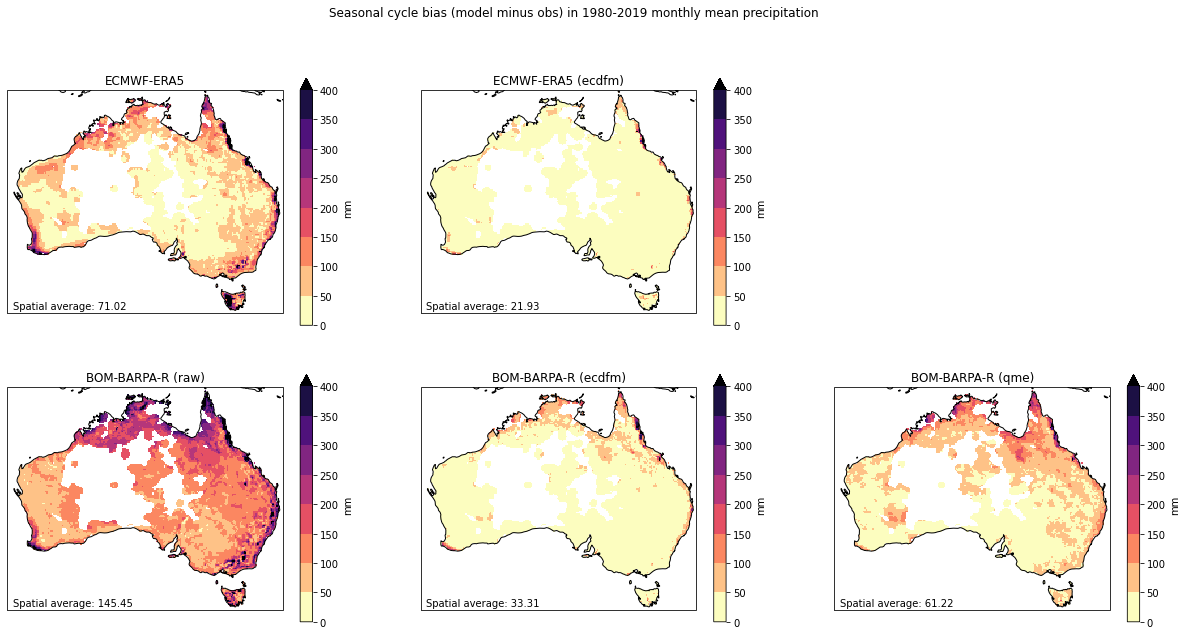

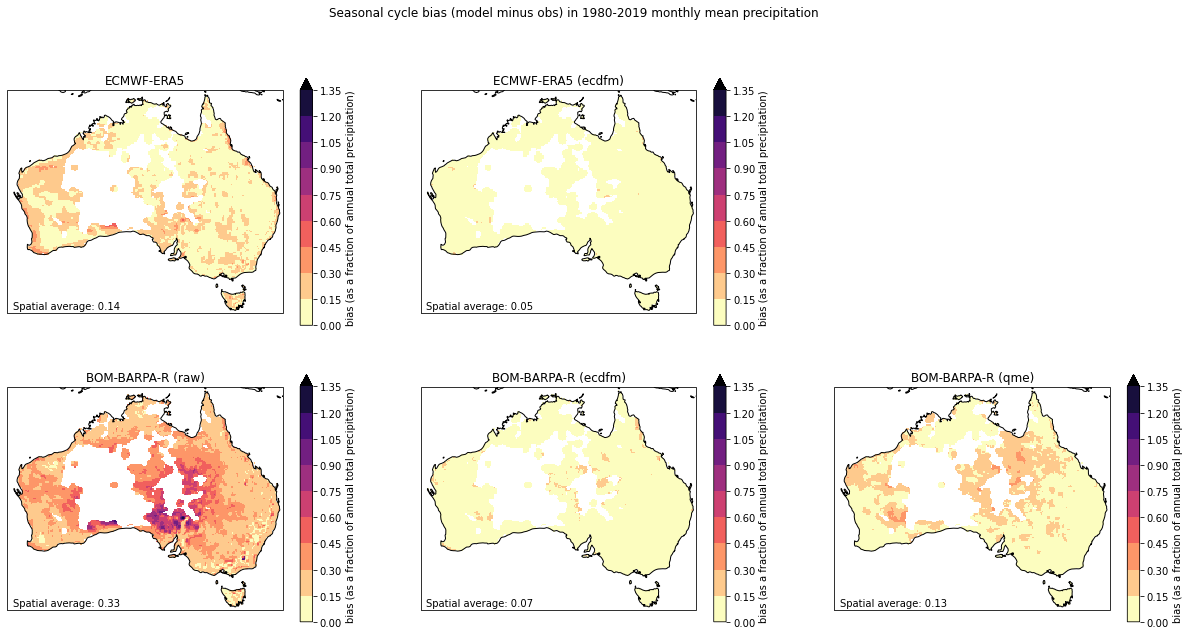

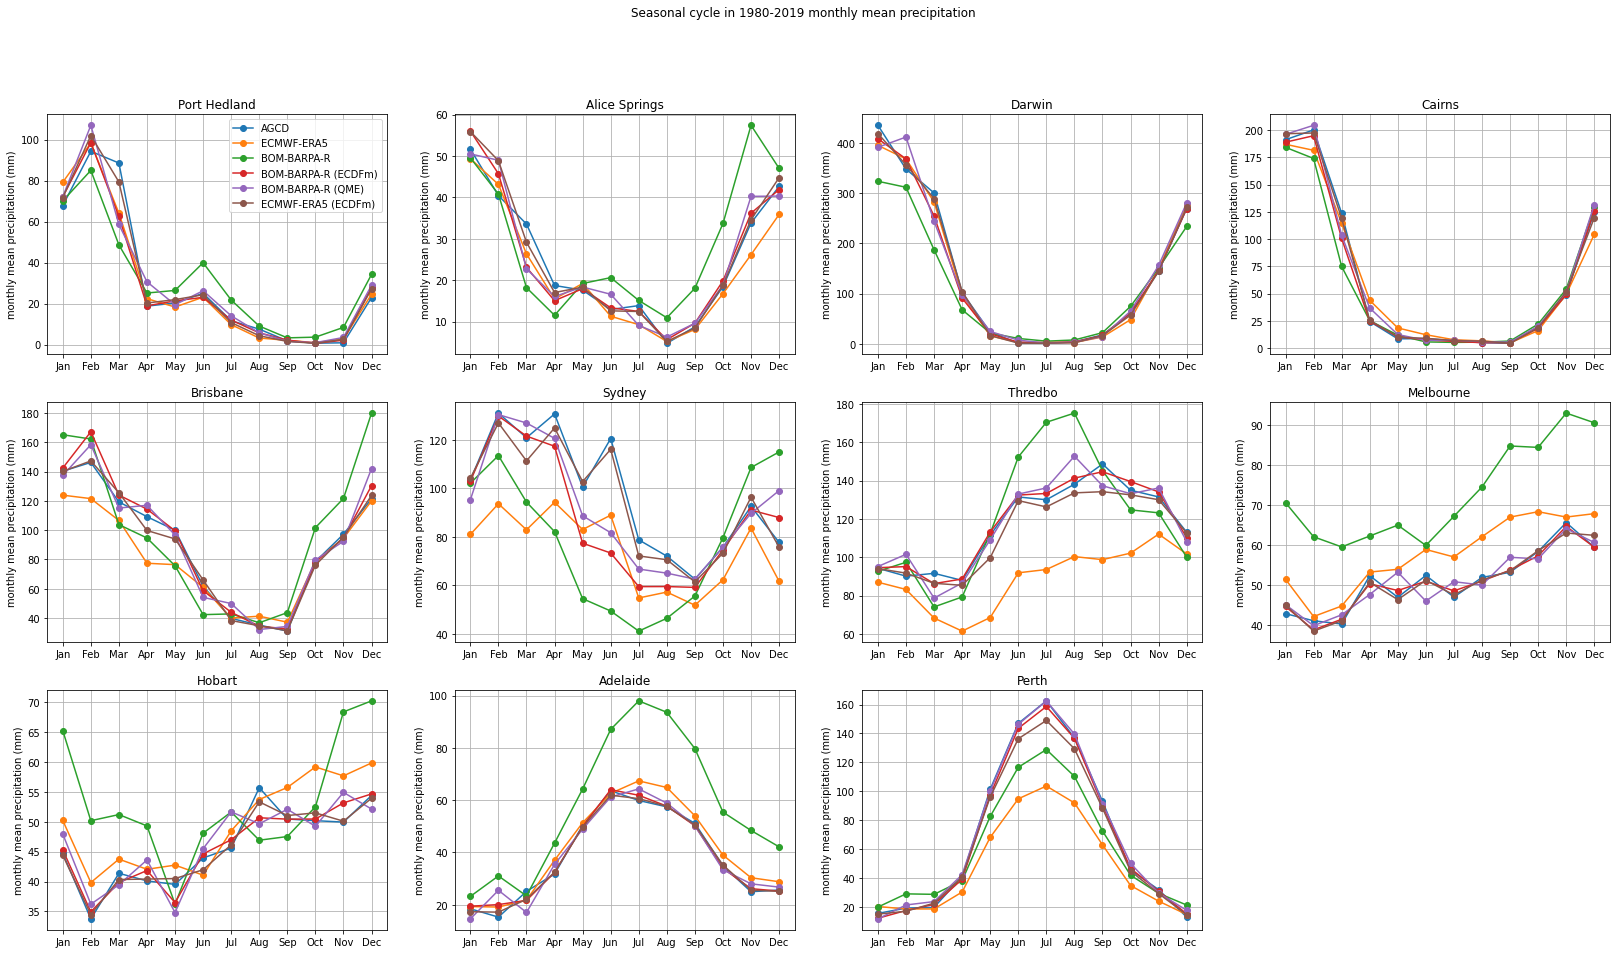

In [20]:
rcm = 'BOM-BARPA-R'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, cities=True)

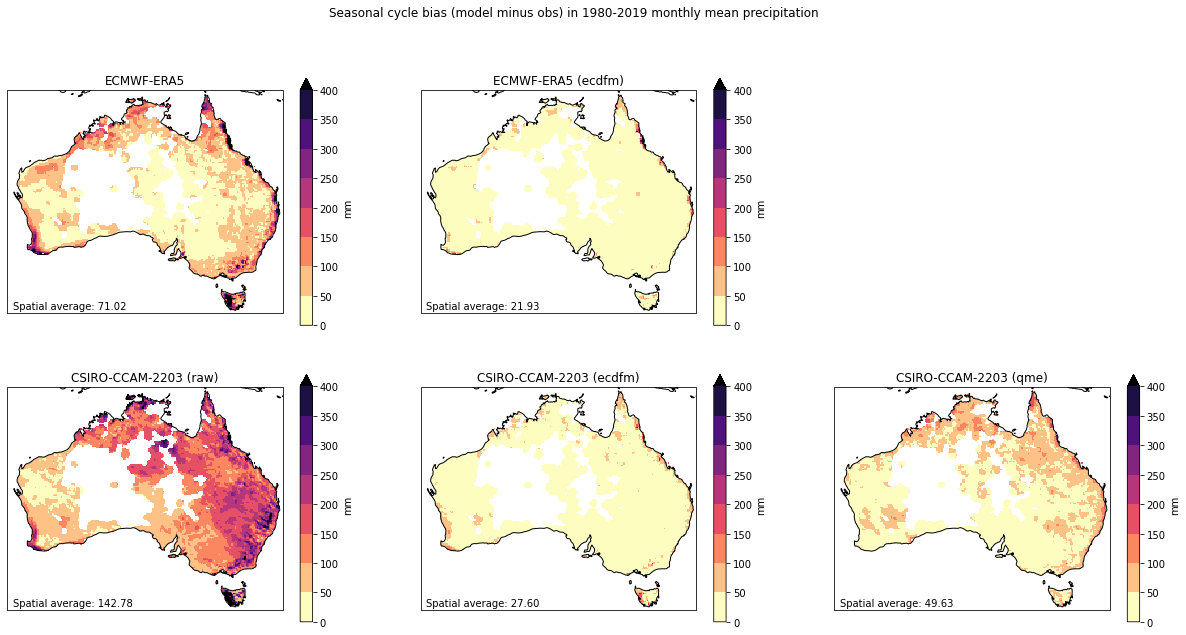

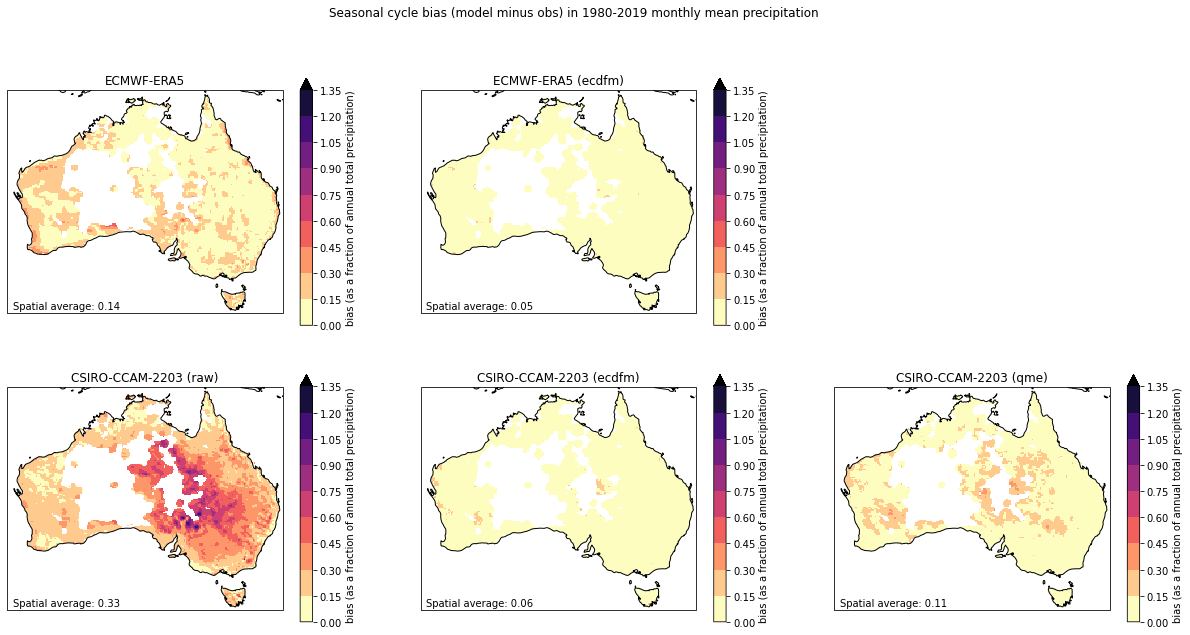

In [21]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, cities=False)

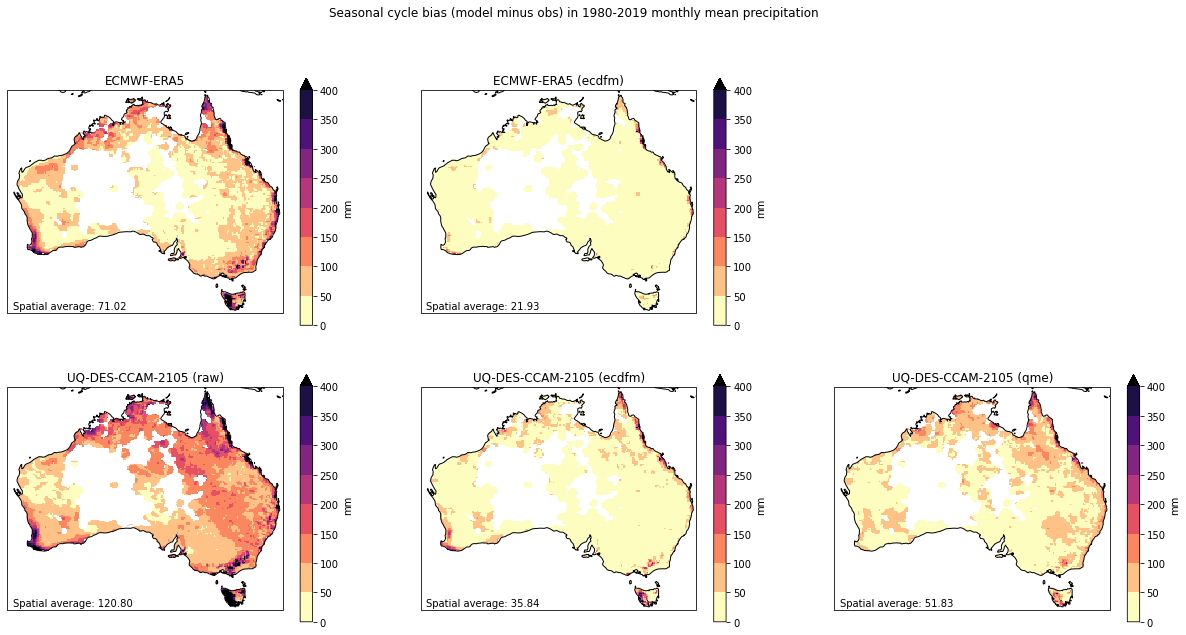

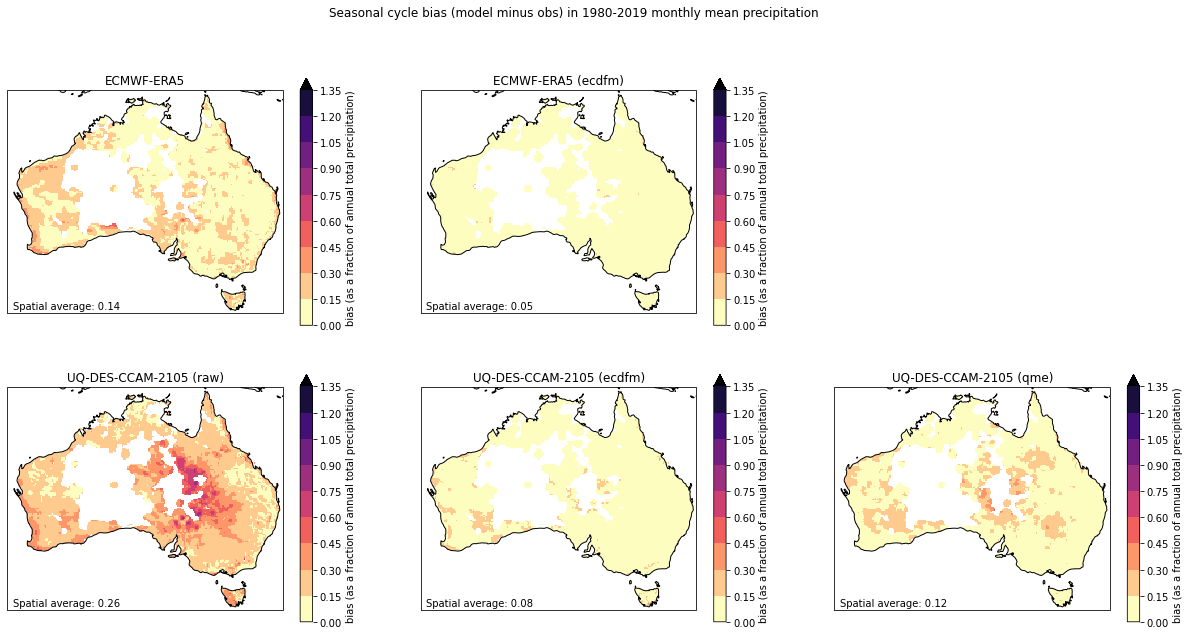

In [22]:
rcm = 'UQ-DES-CCAM-2105'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, cities=False)

#### ACCESS-ESM1-5

In [23]:
gcm = 'CSIRO-ACCESS-ESM1-5'
task = 'historical'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, start_date, end_date)
da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

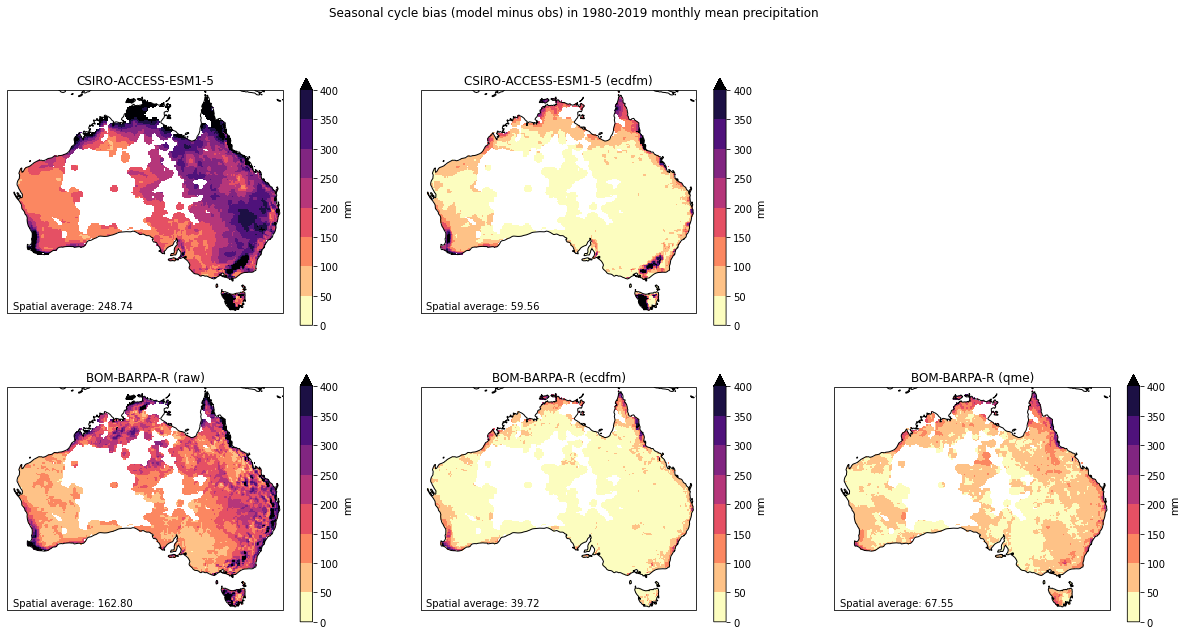

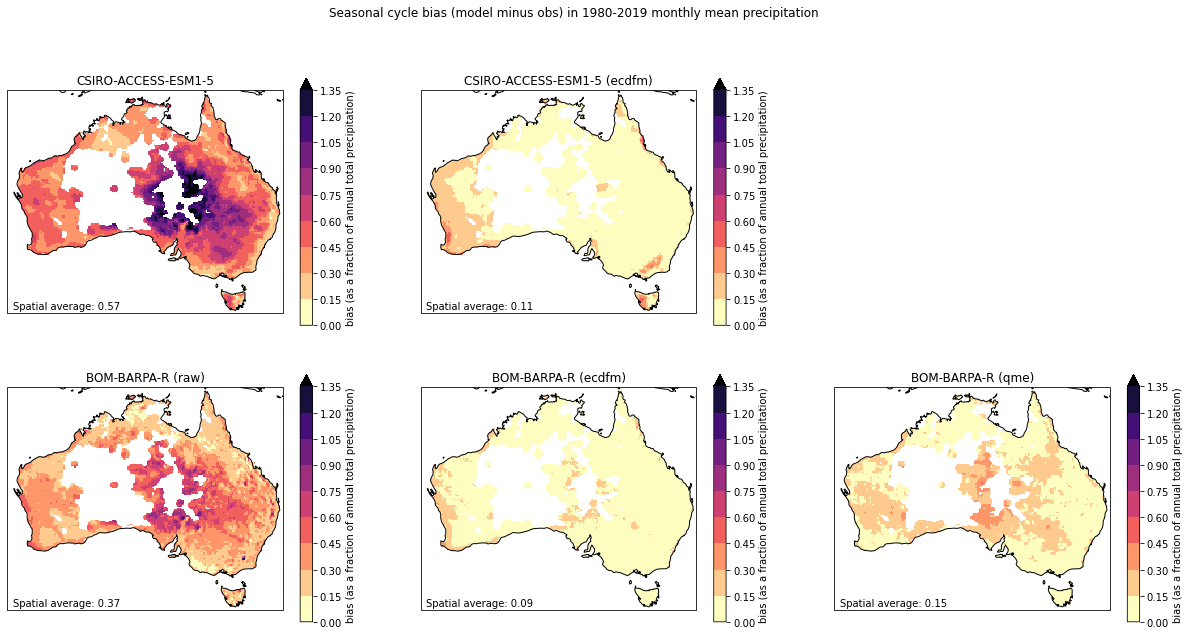

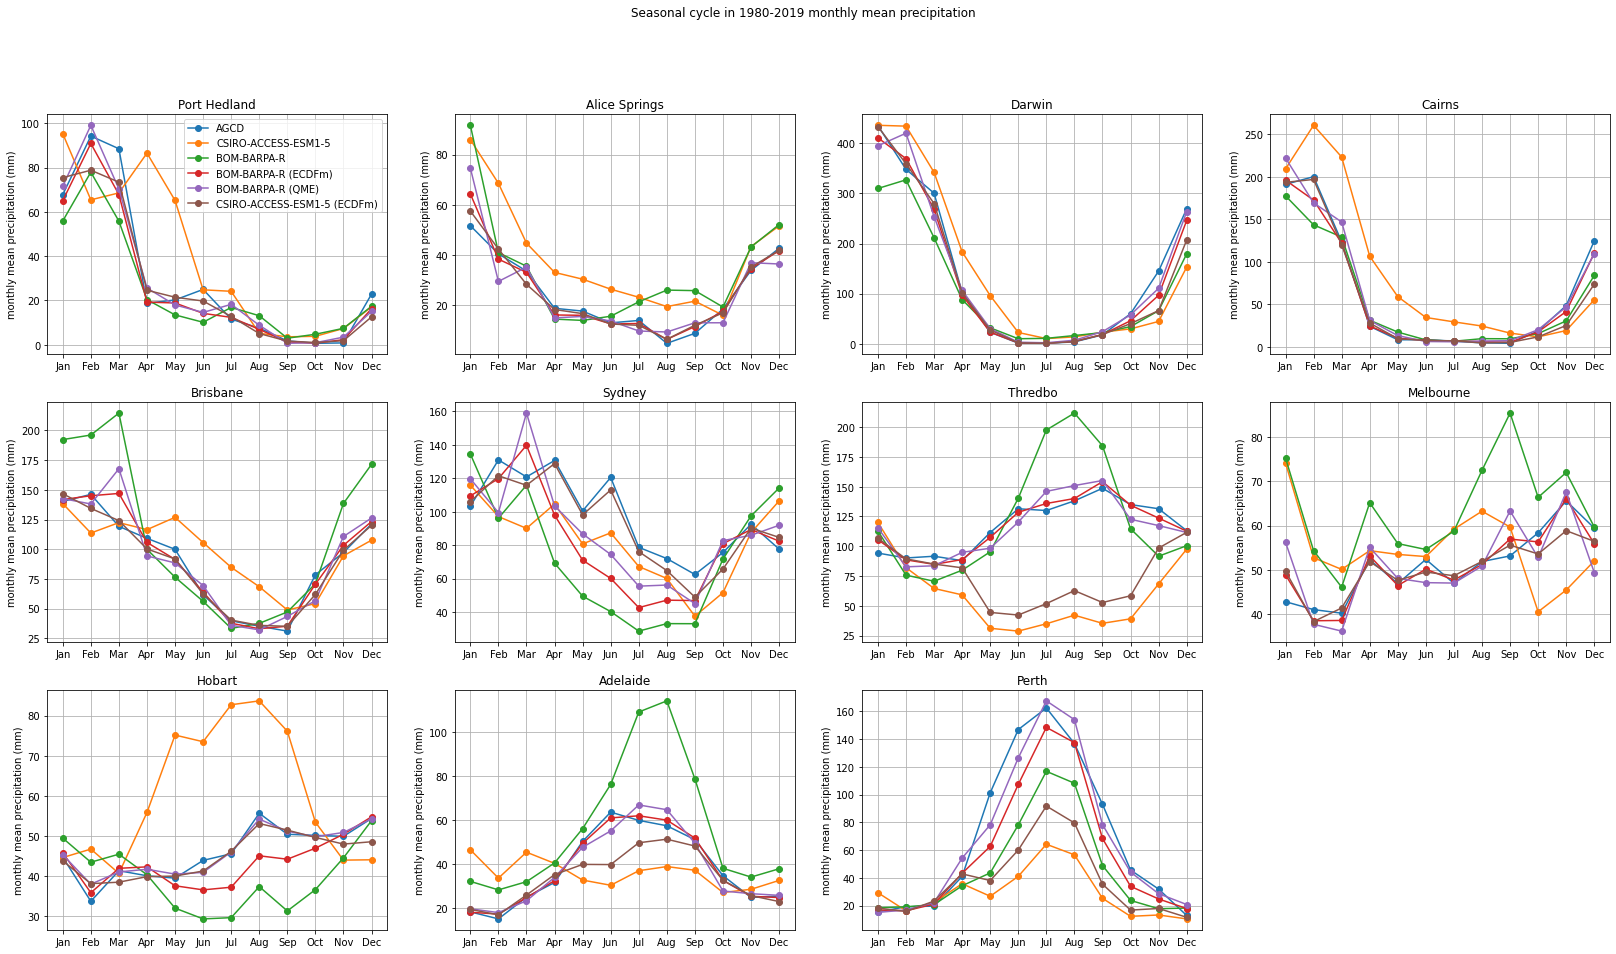

In [24]:
rcm = 'BOM-BARPA-R'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, cities=True)

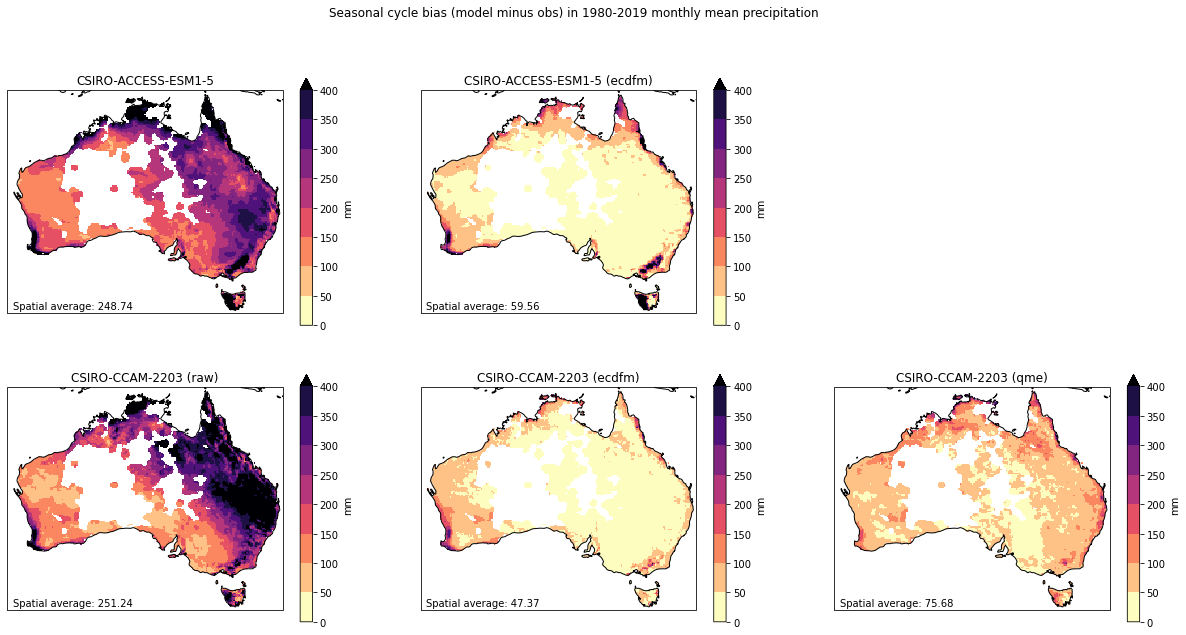

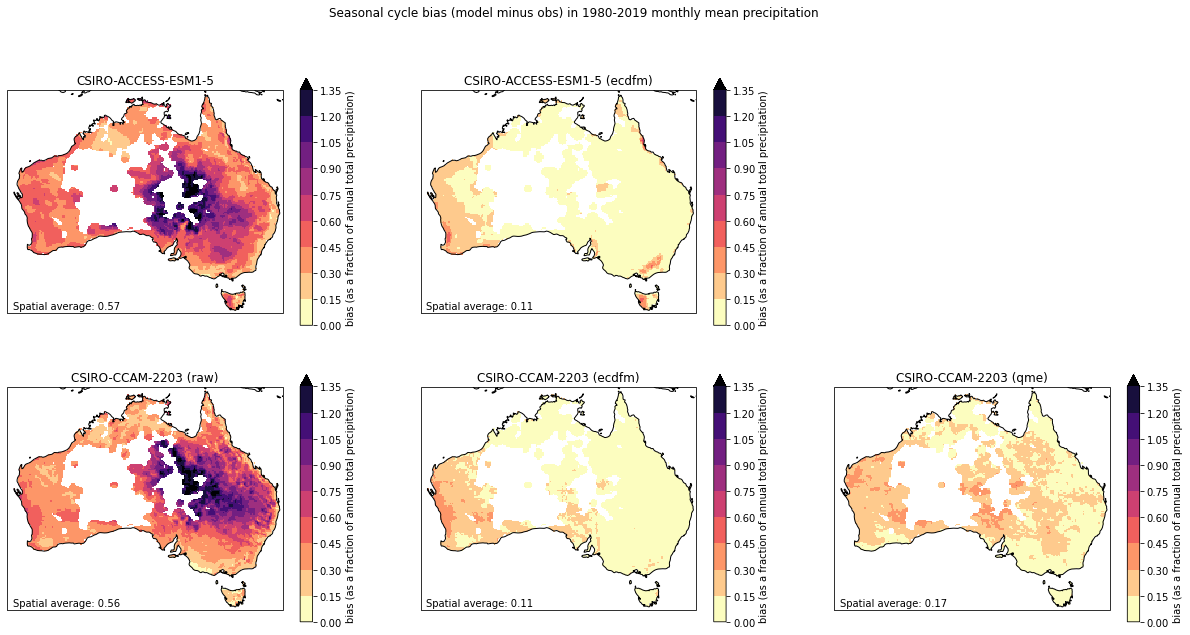

In [25]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, cities=False)

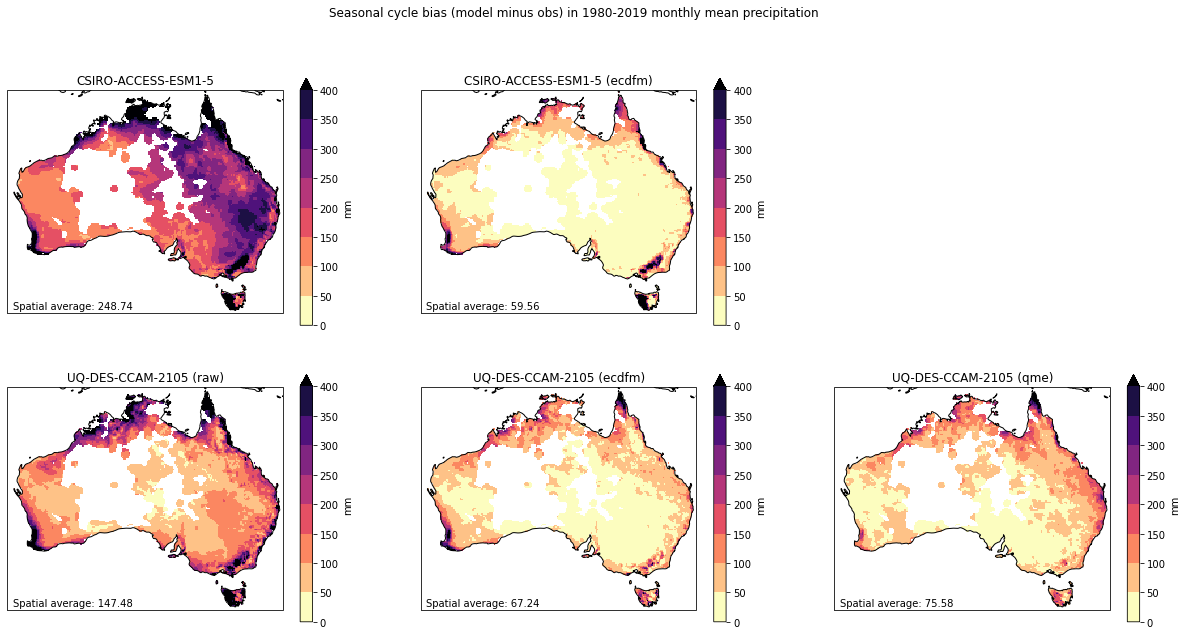

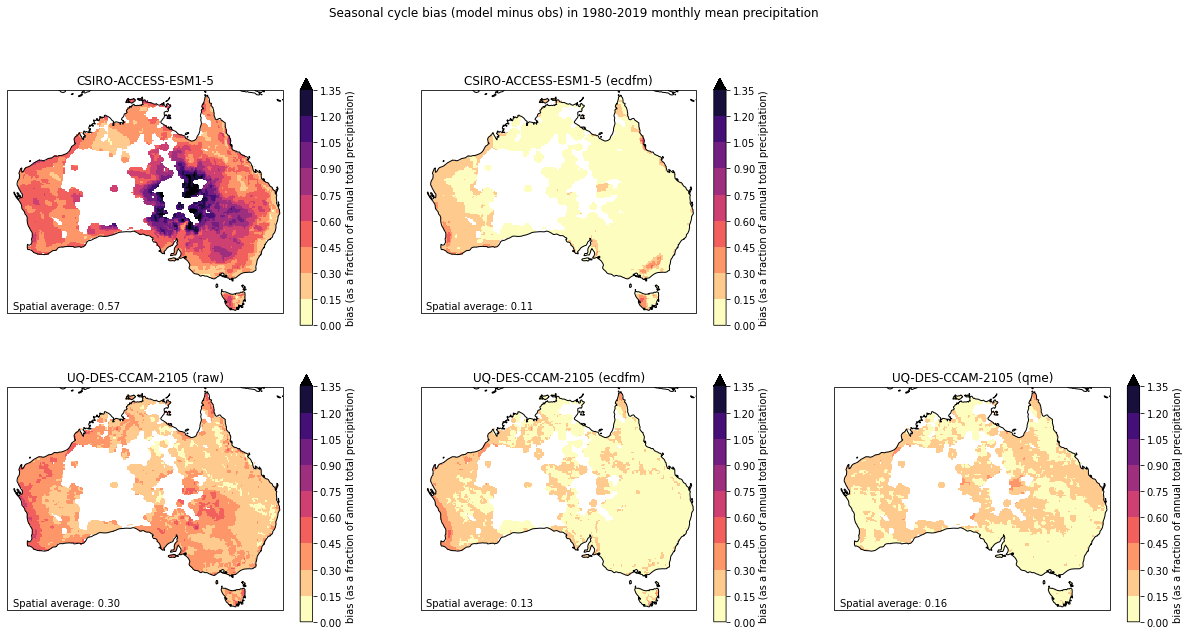

In [26]:
rcm = 'UQ-DES-CCAM-2105'
plot_rcm(da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, cities=False)

## task-xvalidation

#### ERA5

Bias corrected data for the 2000-2019 period, using 1980-1999 as a training period.

In [27]:
gcm = 'ECMWF-ERA5'
task = 'xvalidation'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, start_date, end_date)
da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

training_start, training_end = get_training_time_bounds(gcm)
da_training_obs = get_obs_data(variable, training_start, training_end)

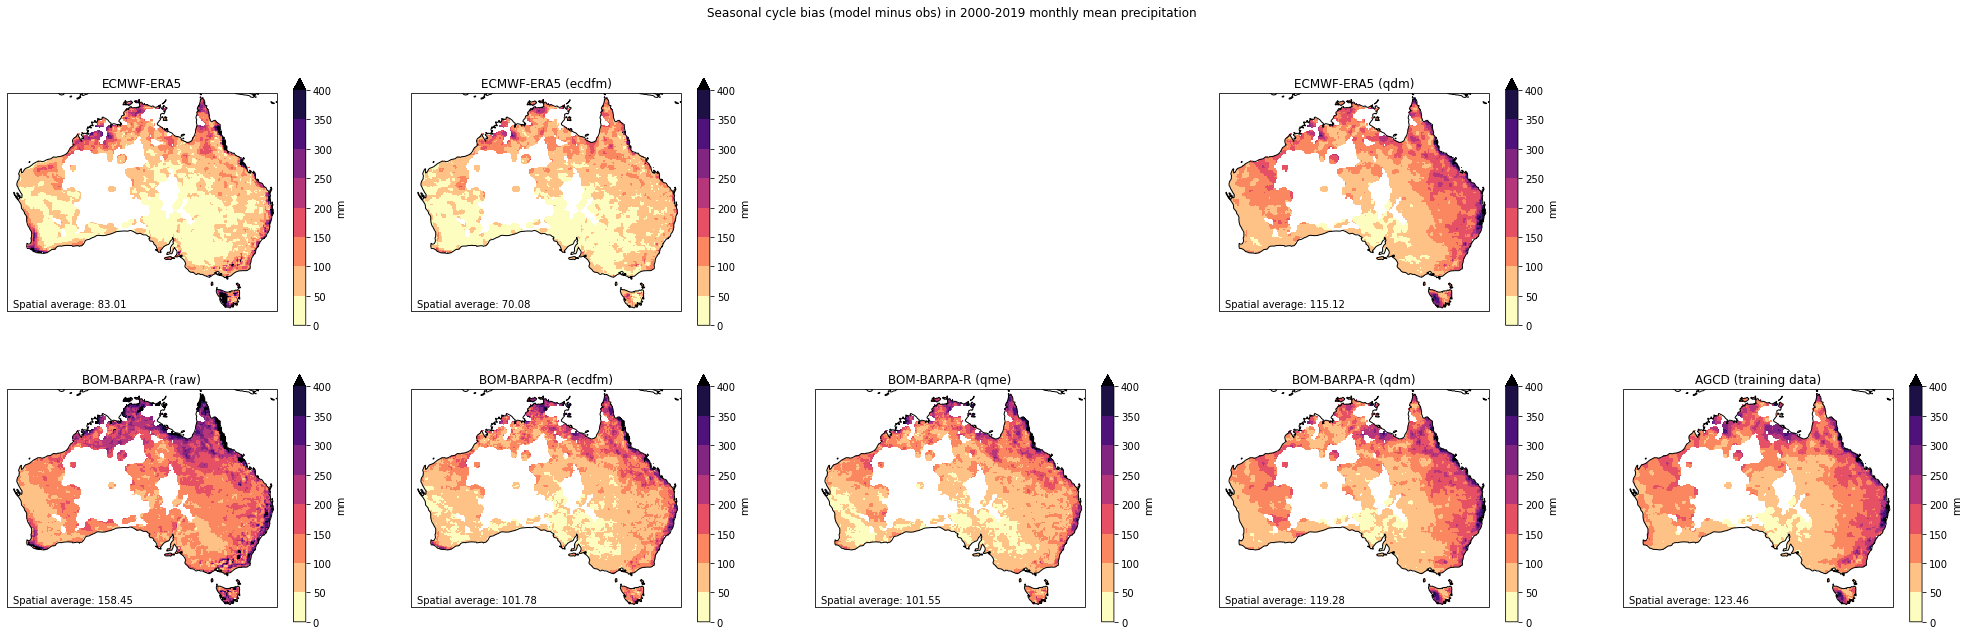

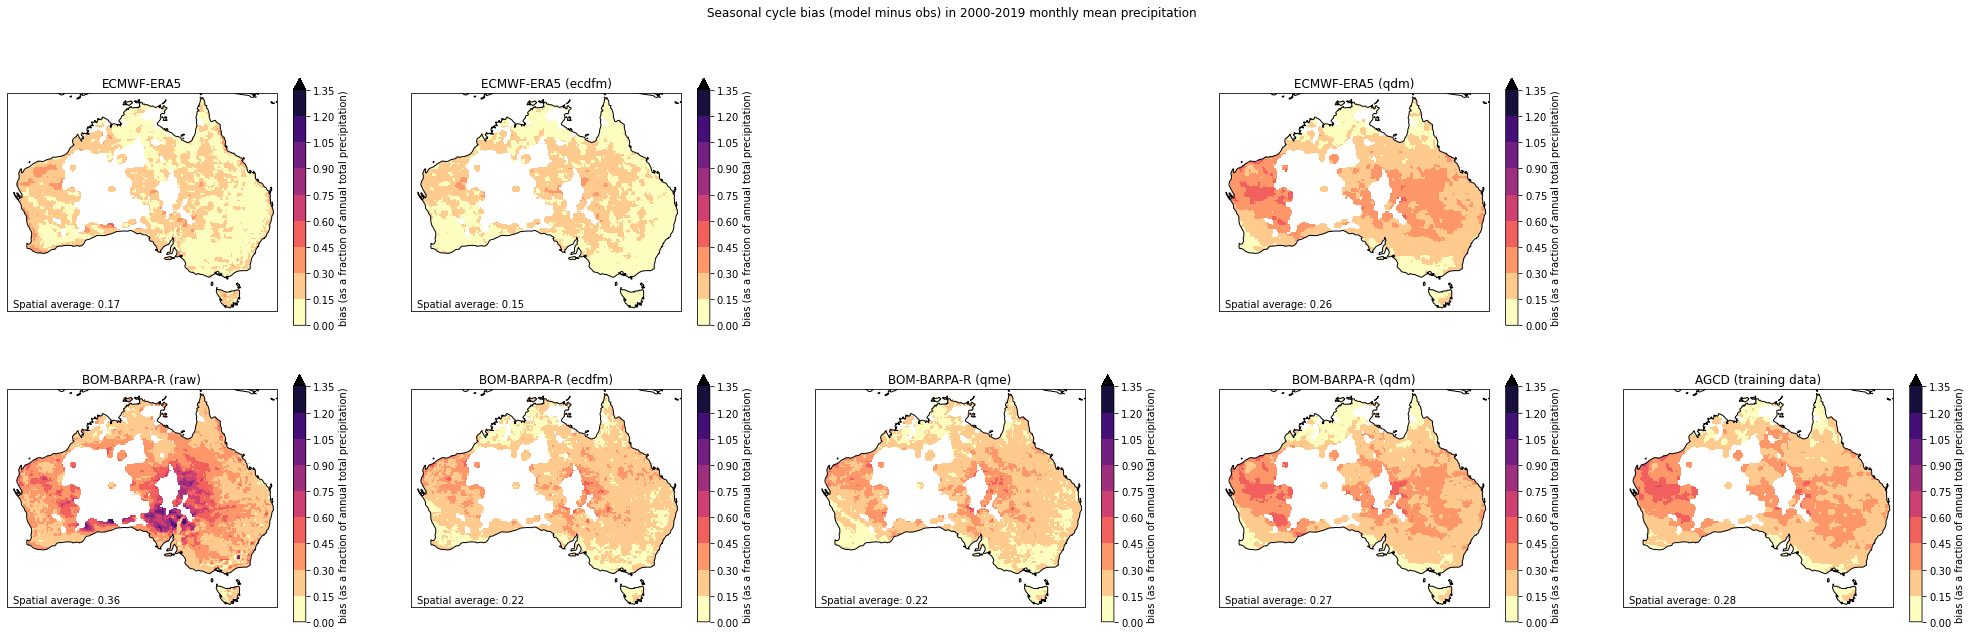

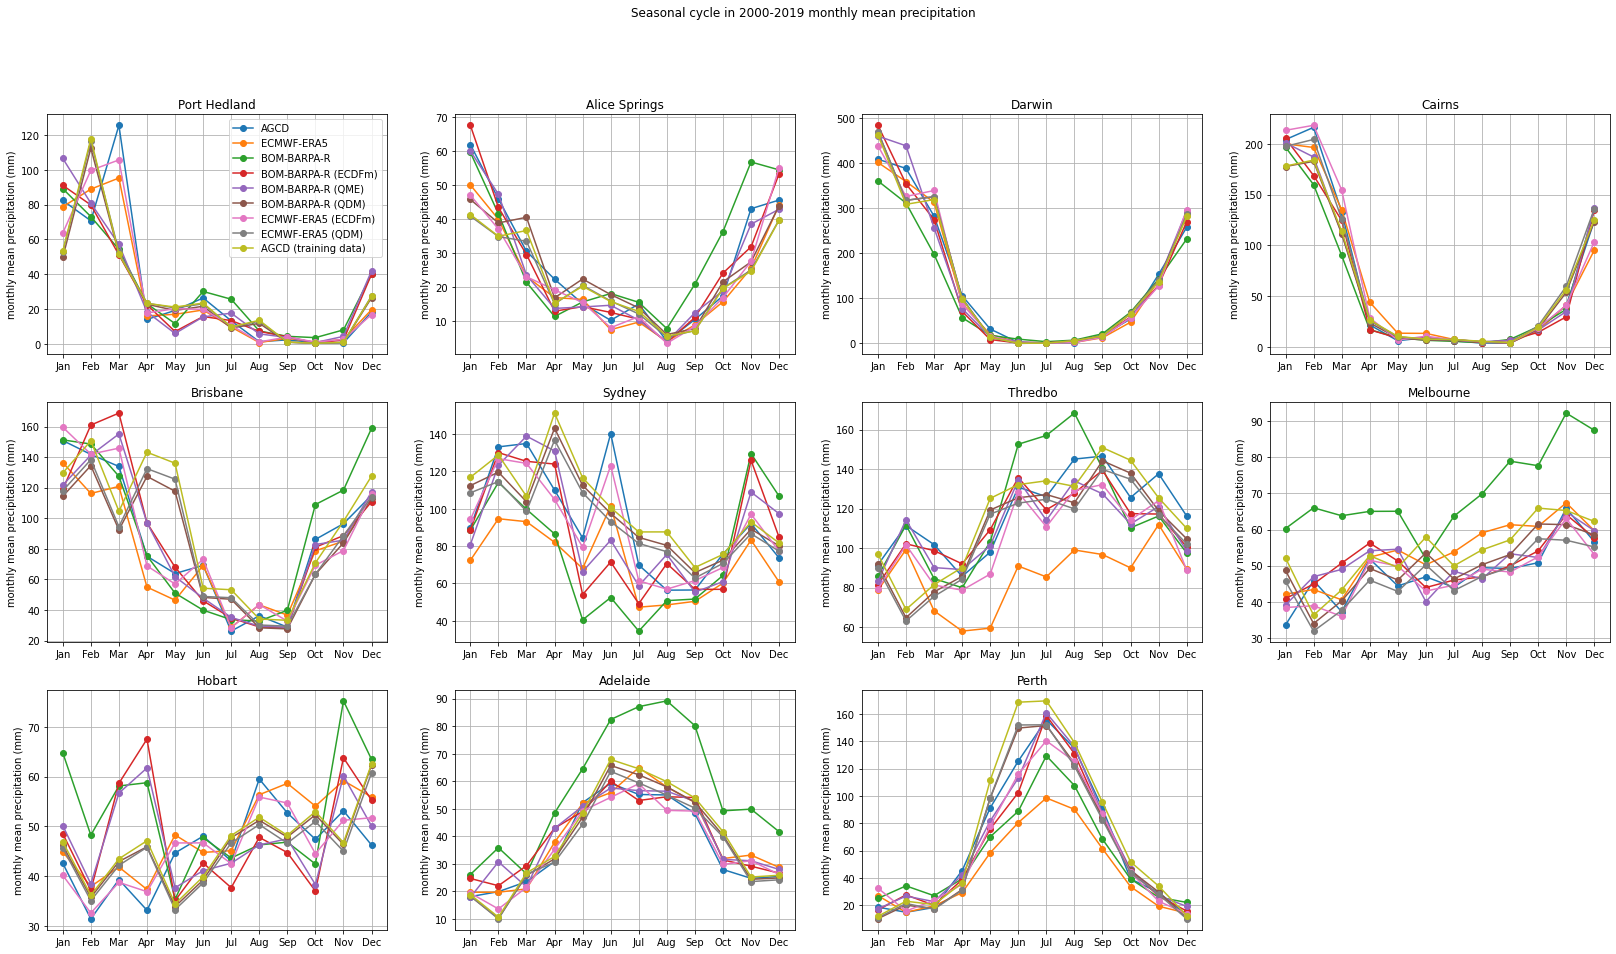

In [28]:
rcm = 'BOM-BARPA-R'
plot_rcm(
    da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs, cities=True
)

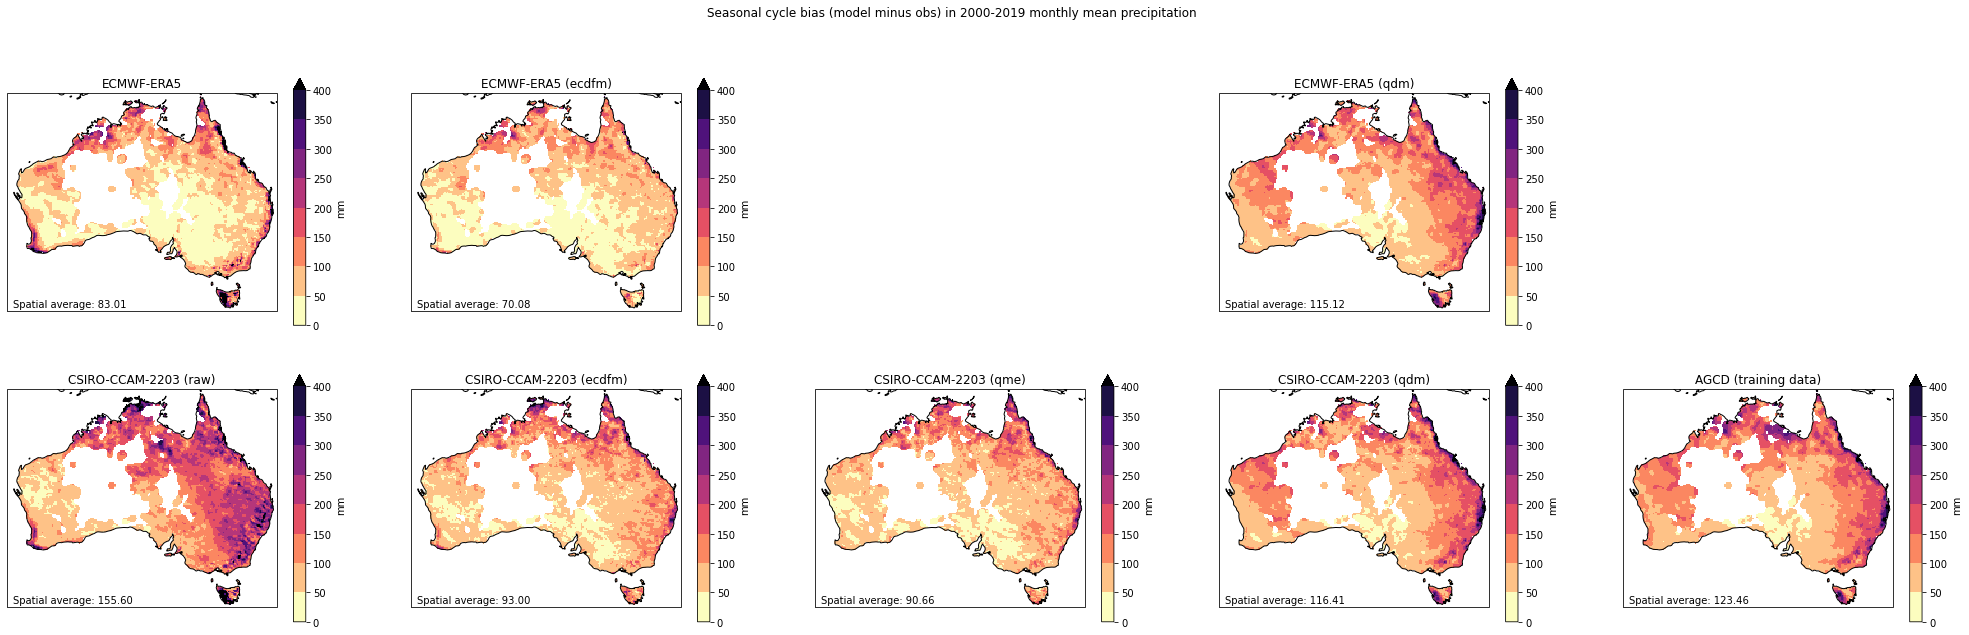

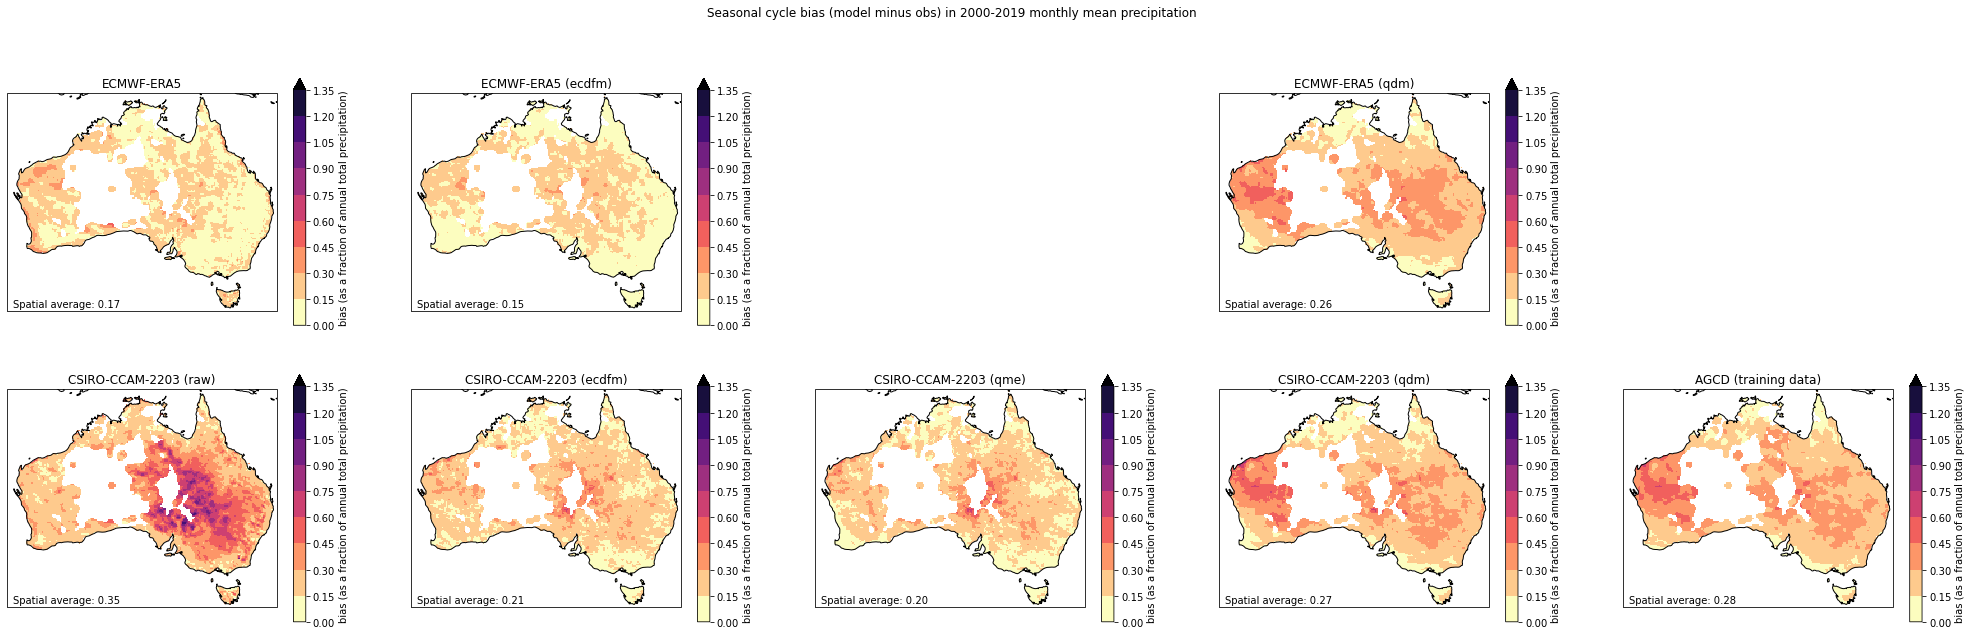

In [29]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(
    da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs, cities=False
)

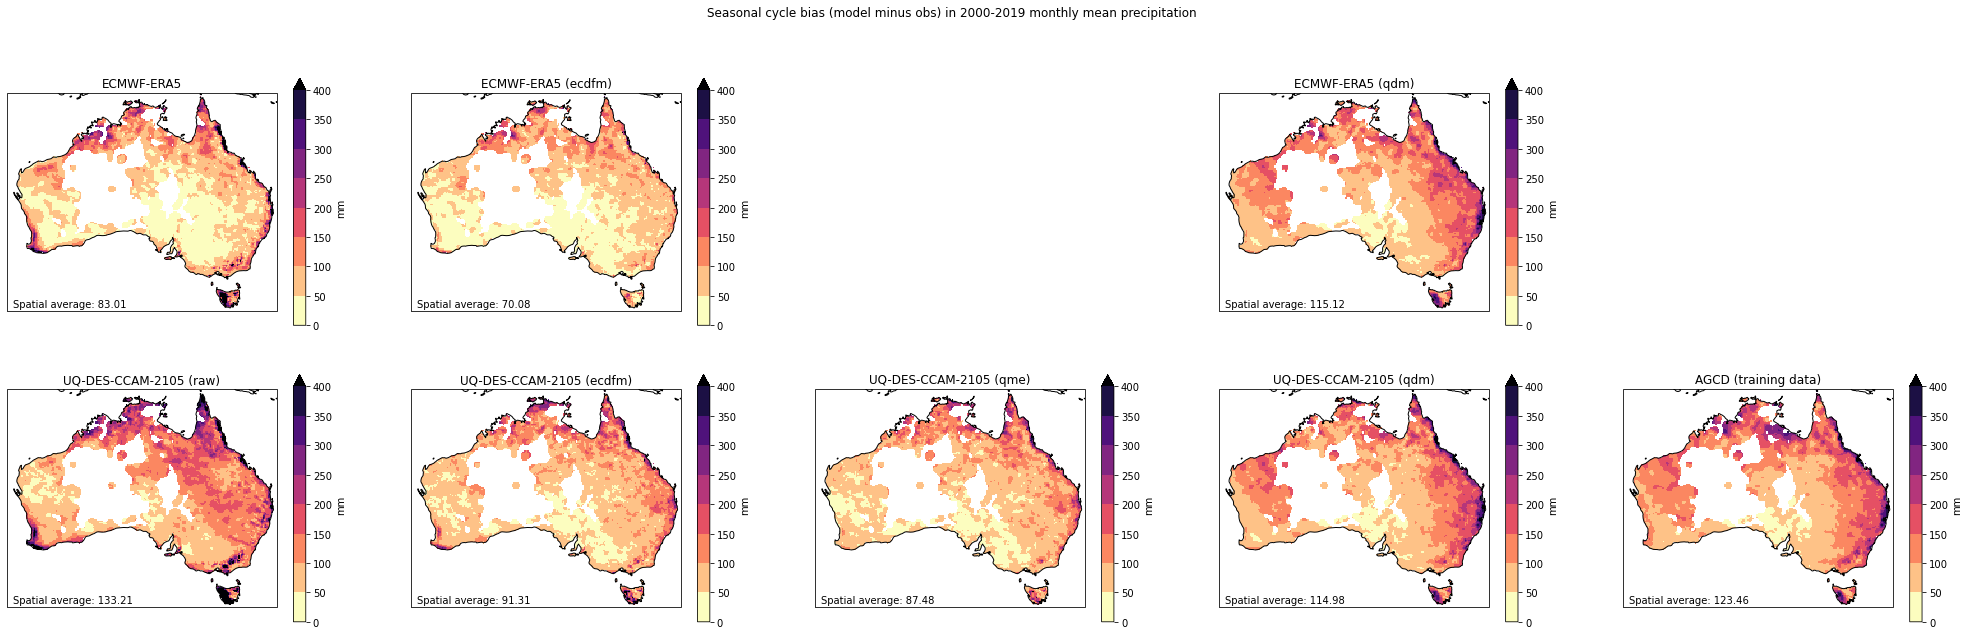

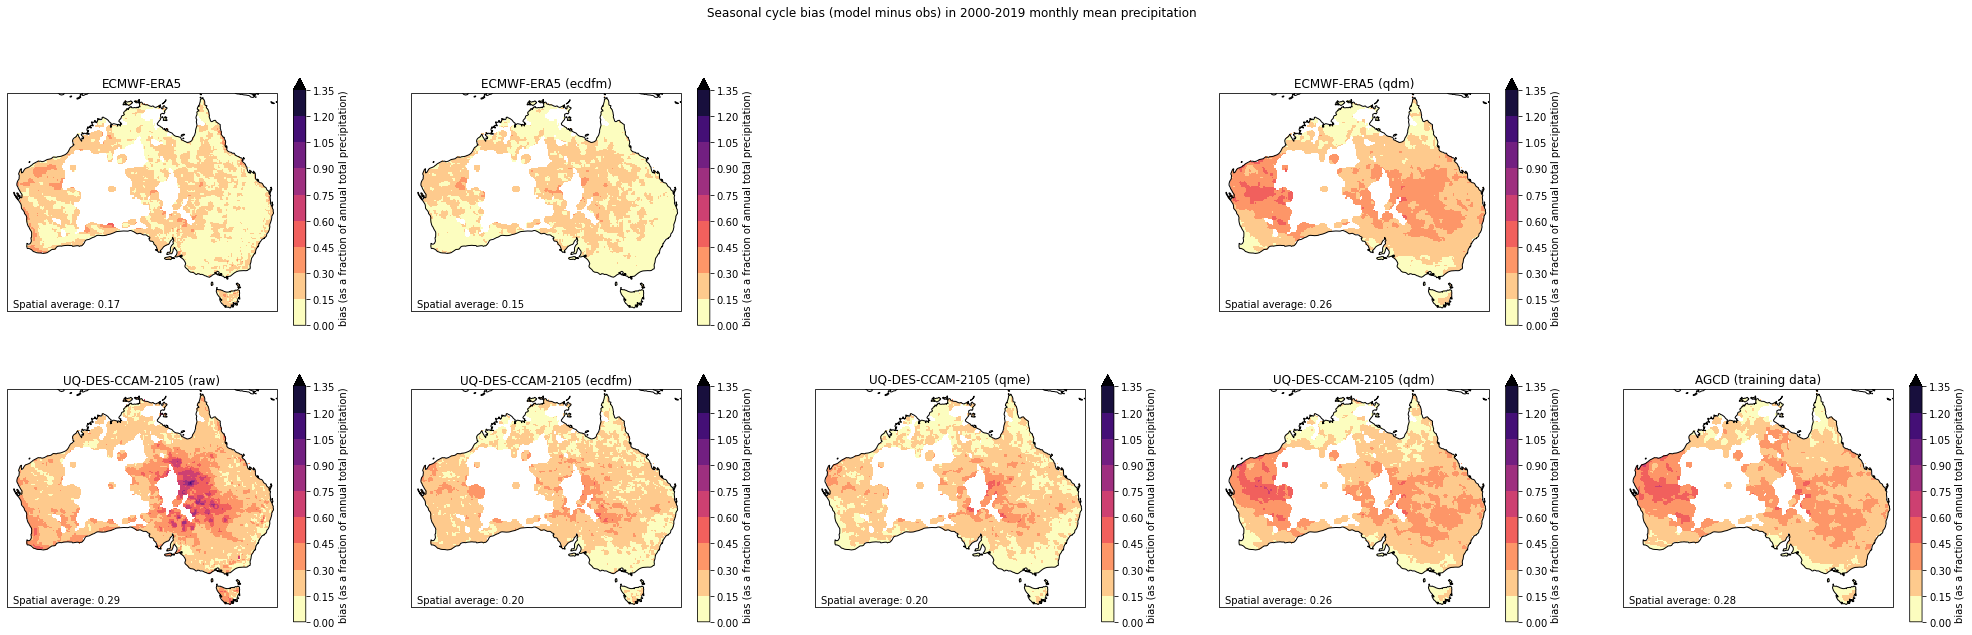

In [30]:
rcm = 'UQ-DES-CCAM-2105'
plot_rcm(
    da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs, cities=False
)

#### ACCESS-ESM1-5

Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.

In [13]:
gcm = 'CSIRO-ACCESS-ESM1-5'
task = 'xvalidation'
start_date, end_date = get_assessment_time_bounds(gcm, task)
da_obs = get_obs_data(variable, start_date, end_date)
da_gcm = get_gcm_data(variable, gcm, start_date, end_date)
gcm_bc_dict = get_bias_corrected_gcm_data(variable, gcm, task, start_date, end_date)

training_start, training_end = get_training_time_bounds(gcm)
da_training_obs = get_obs_data(variable, training_start, training_end)

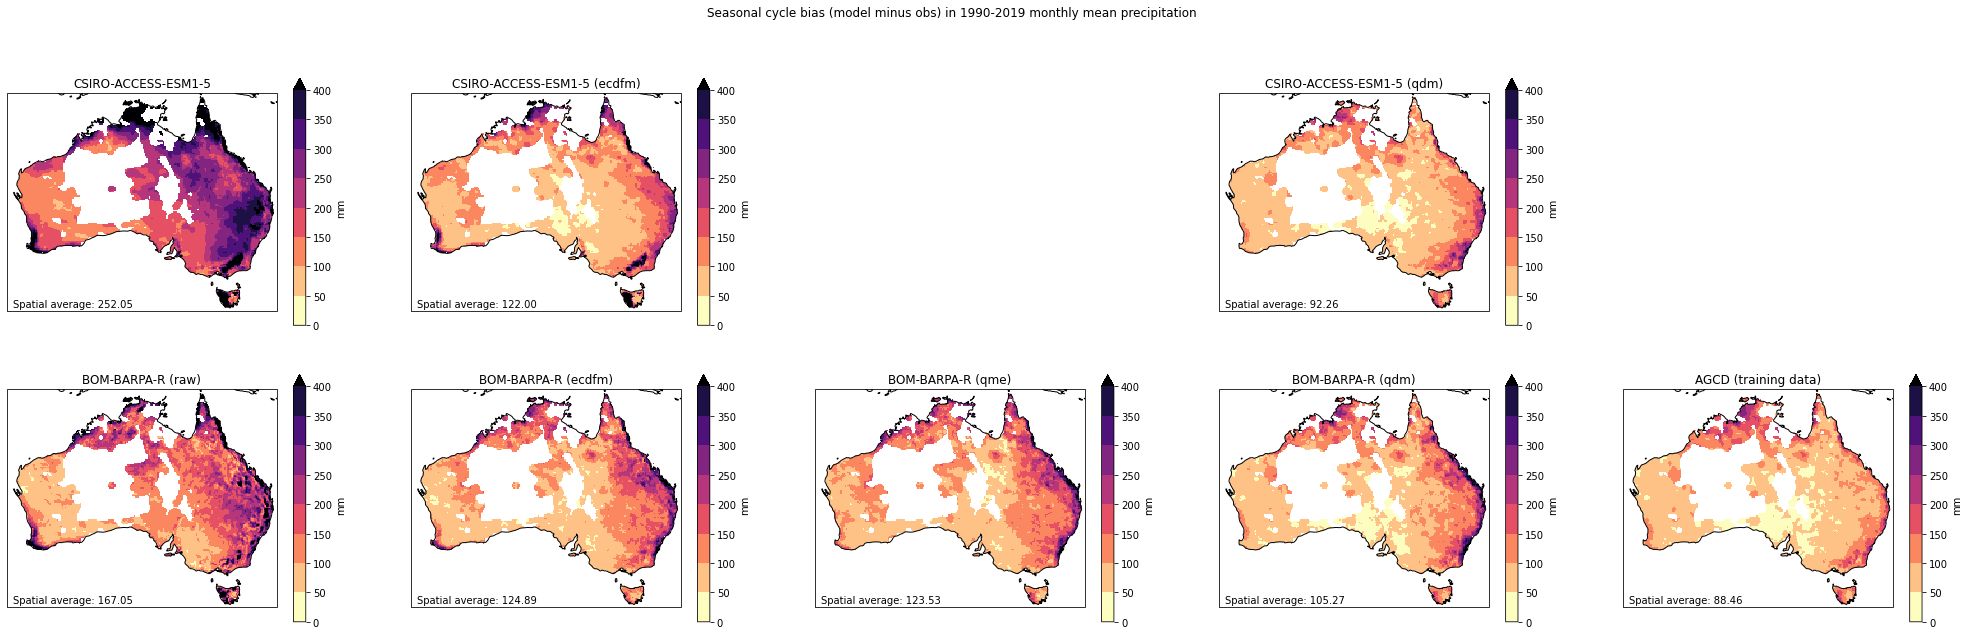

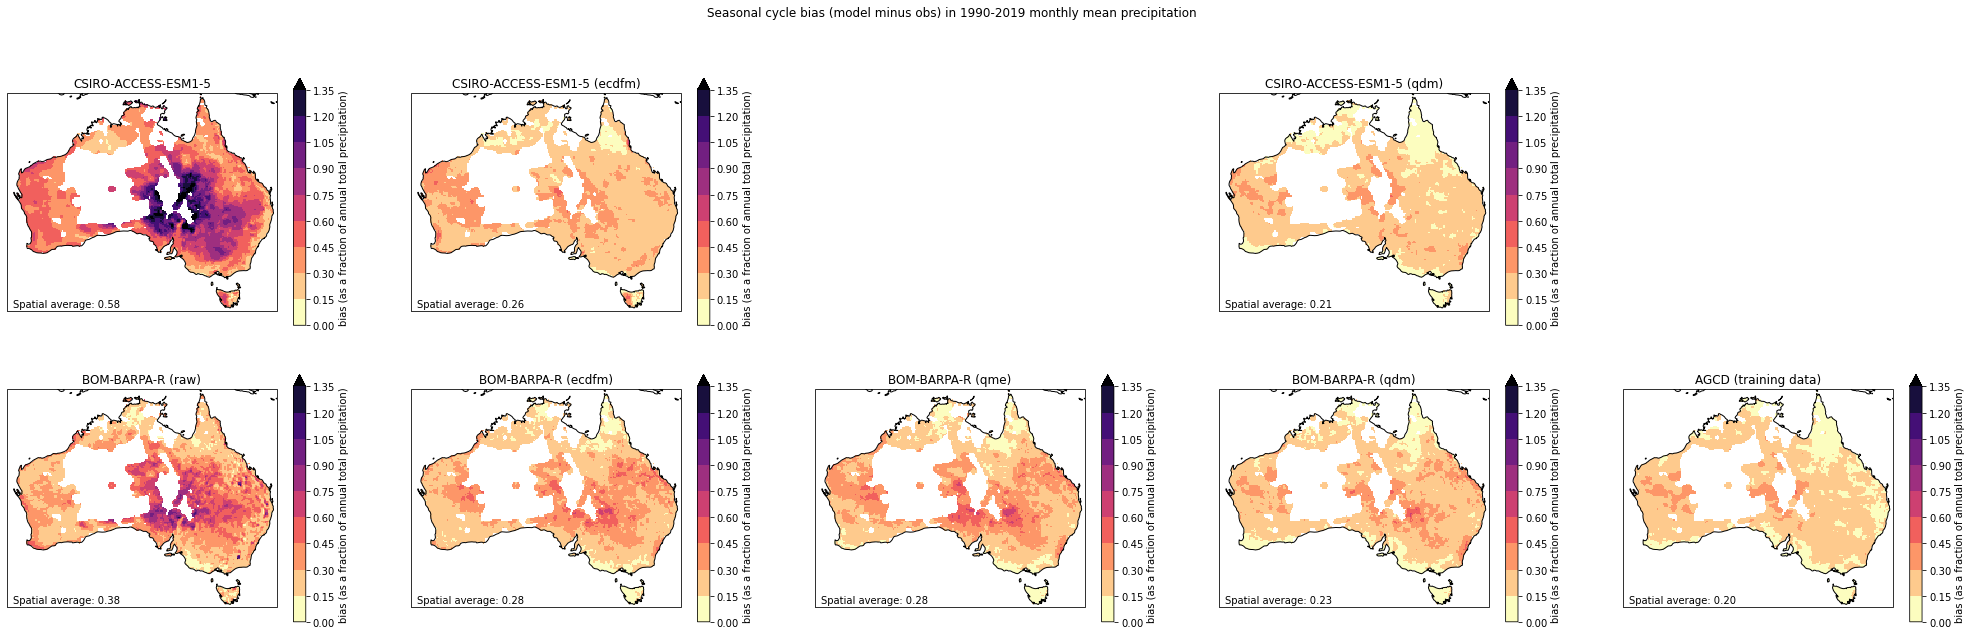

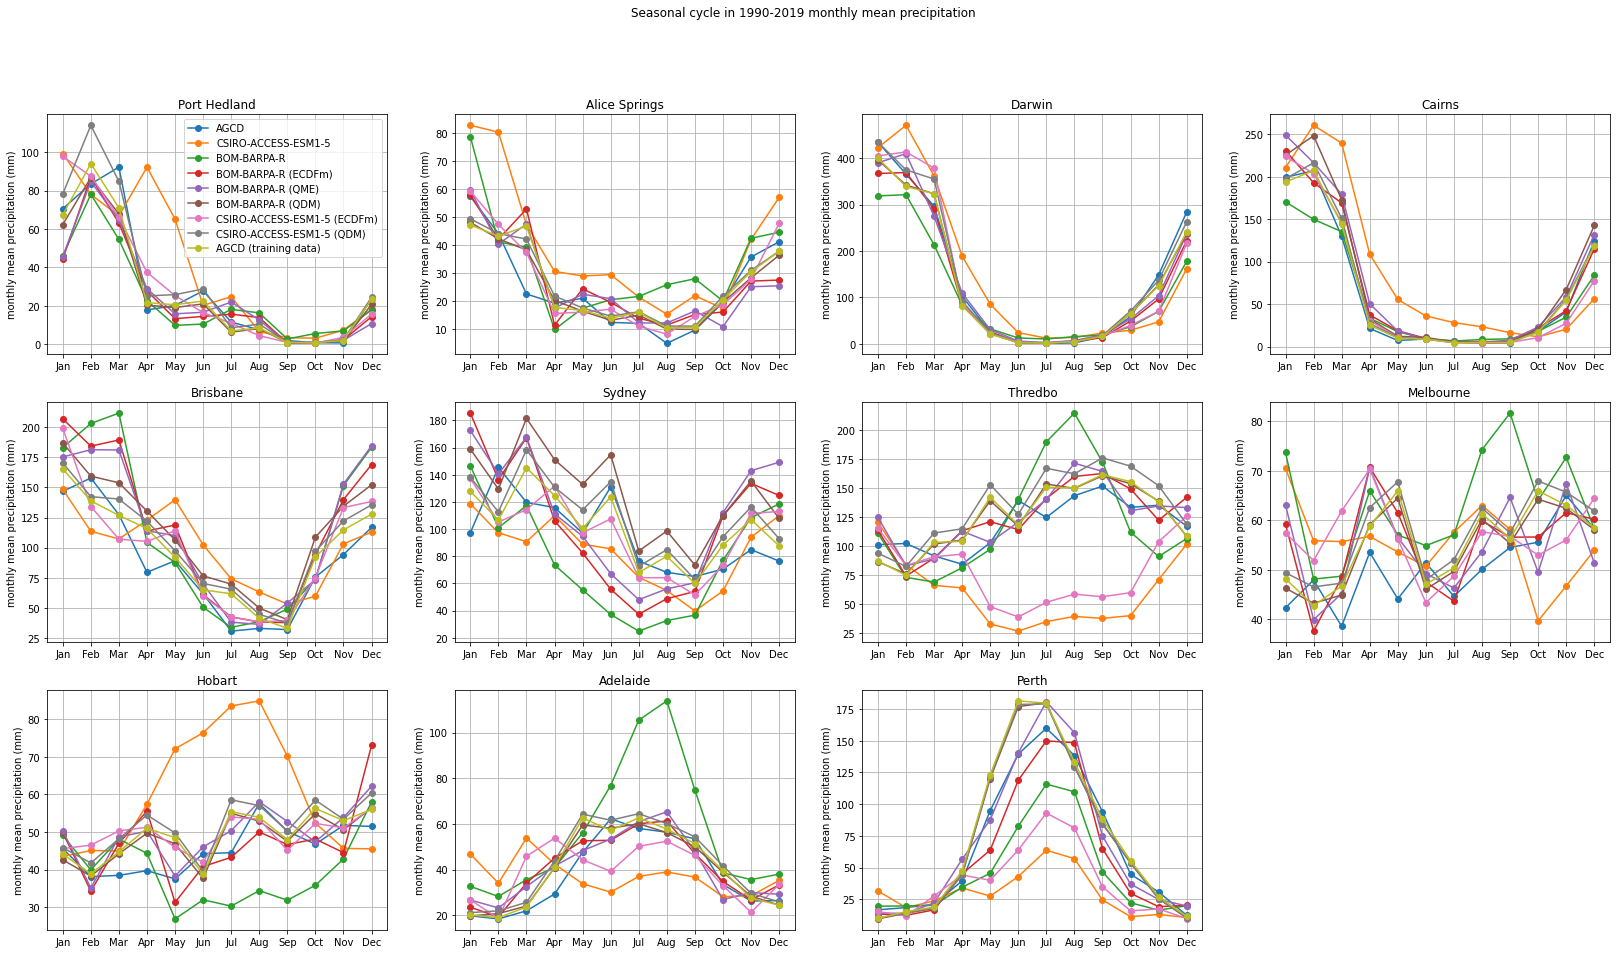

In [14]:
rcm = 'BOM-BARPA-R'
plot_rcm(
    da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs, cities=True
)

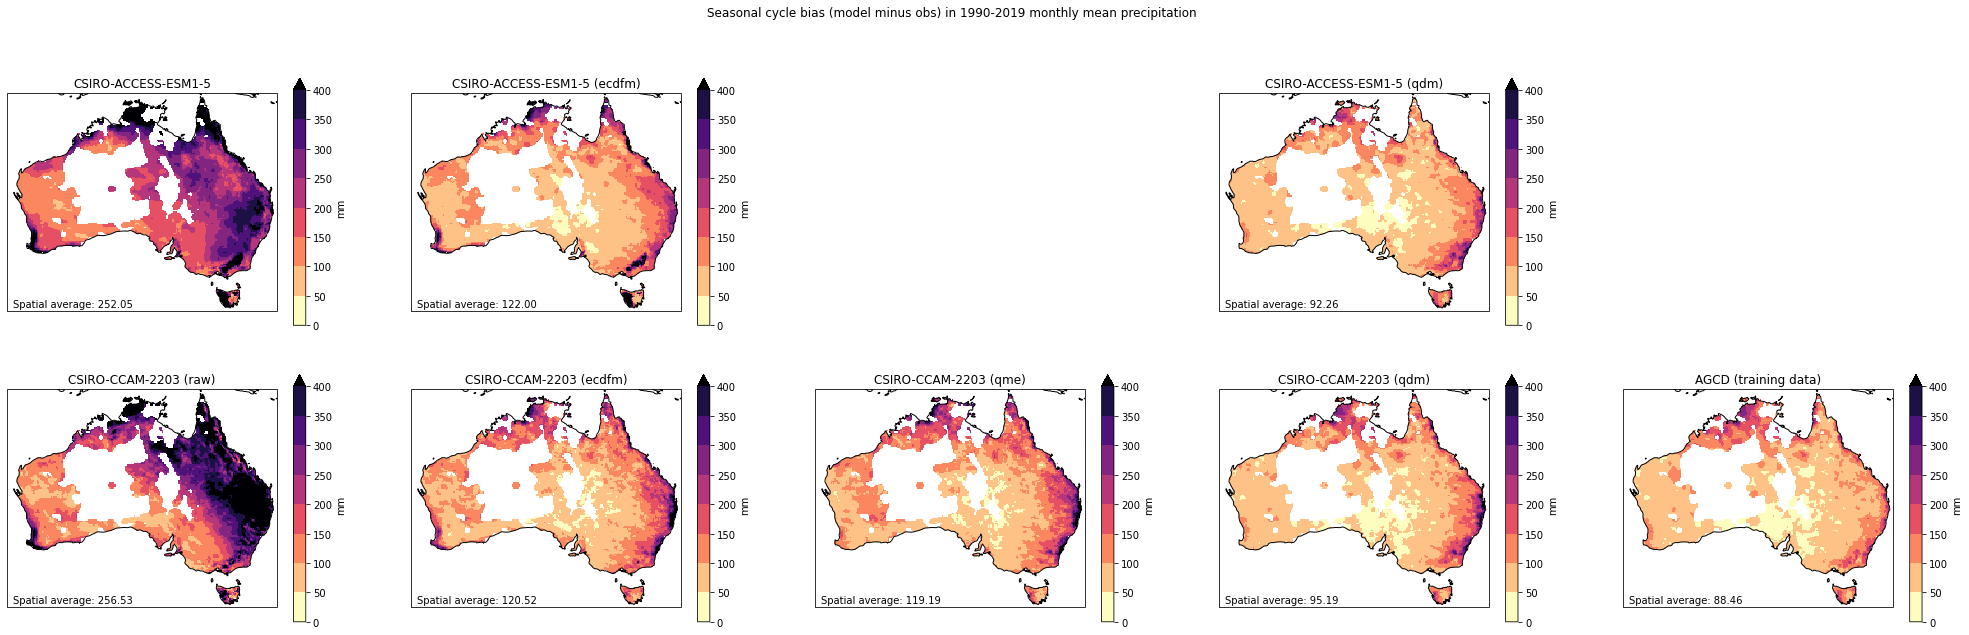

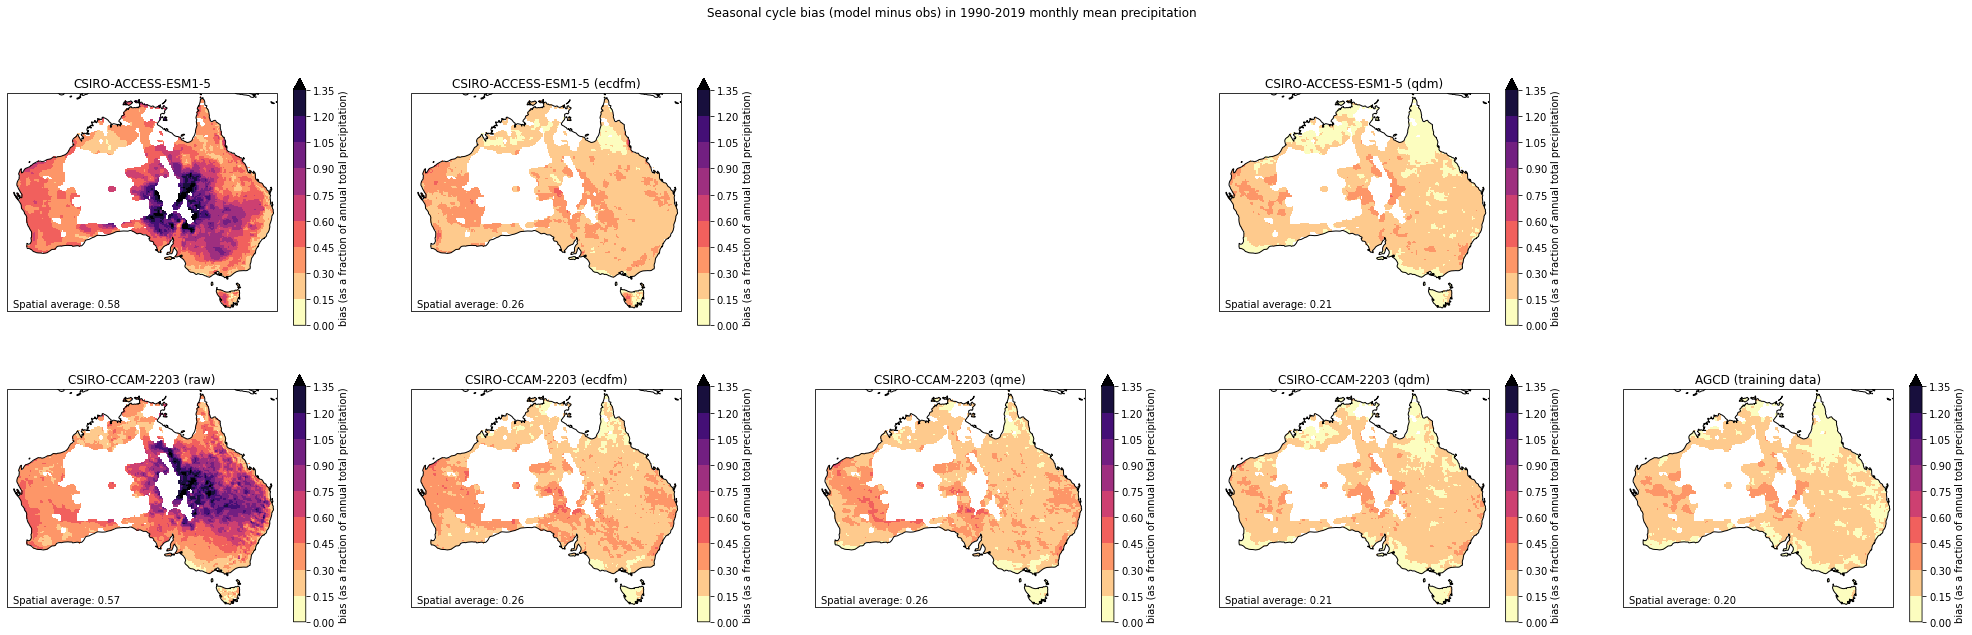

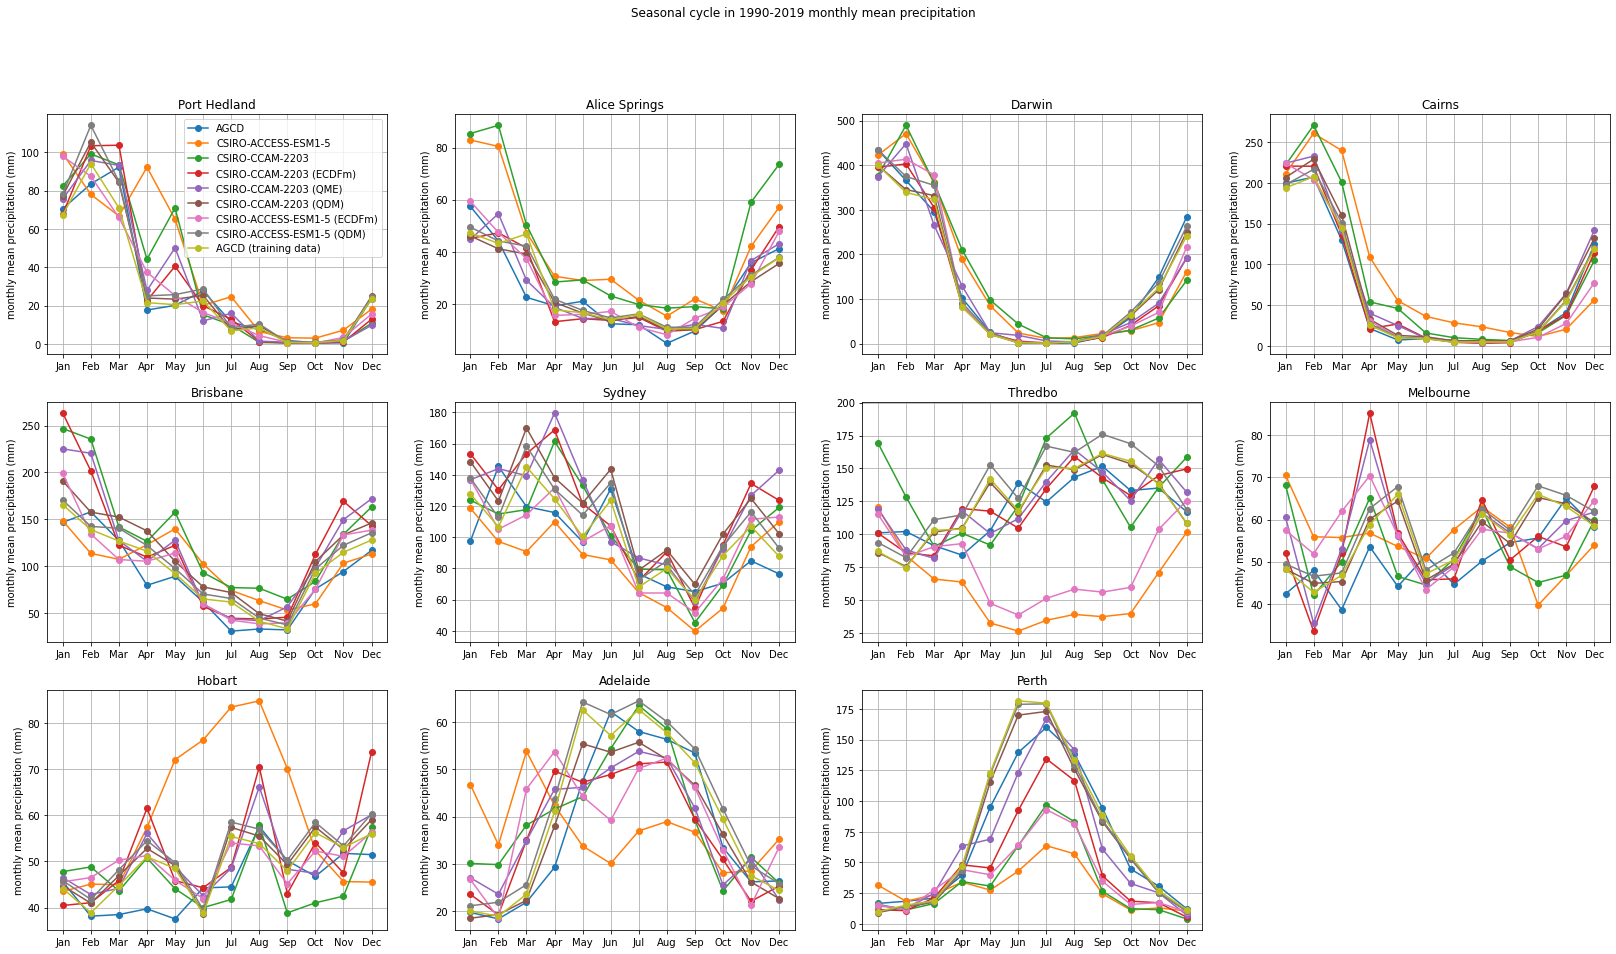

In [17]:
rcm = 'CSIRO-CCAM-2203'
plot_rcm(
    da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs, cities=True
)

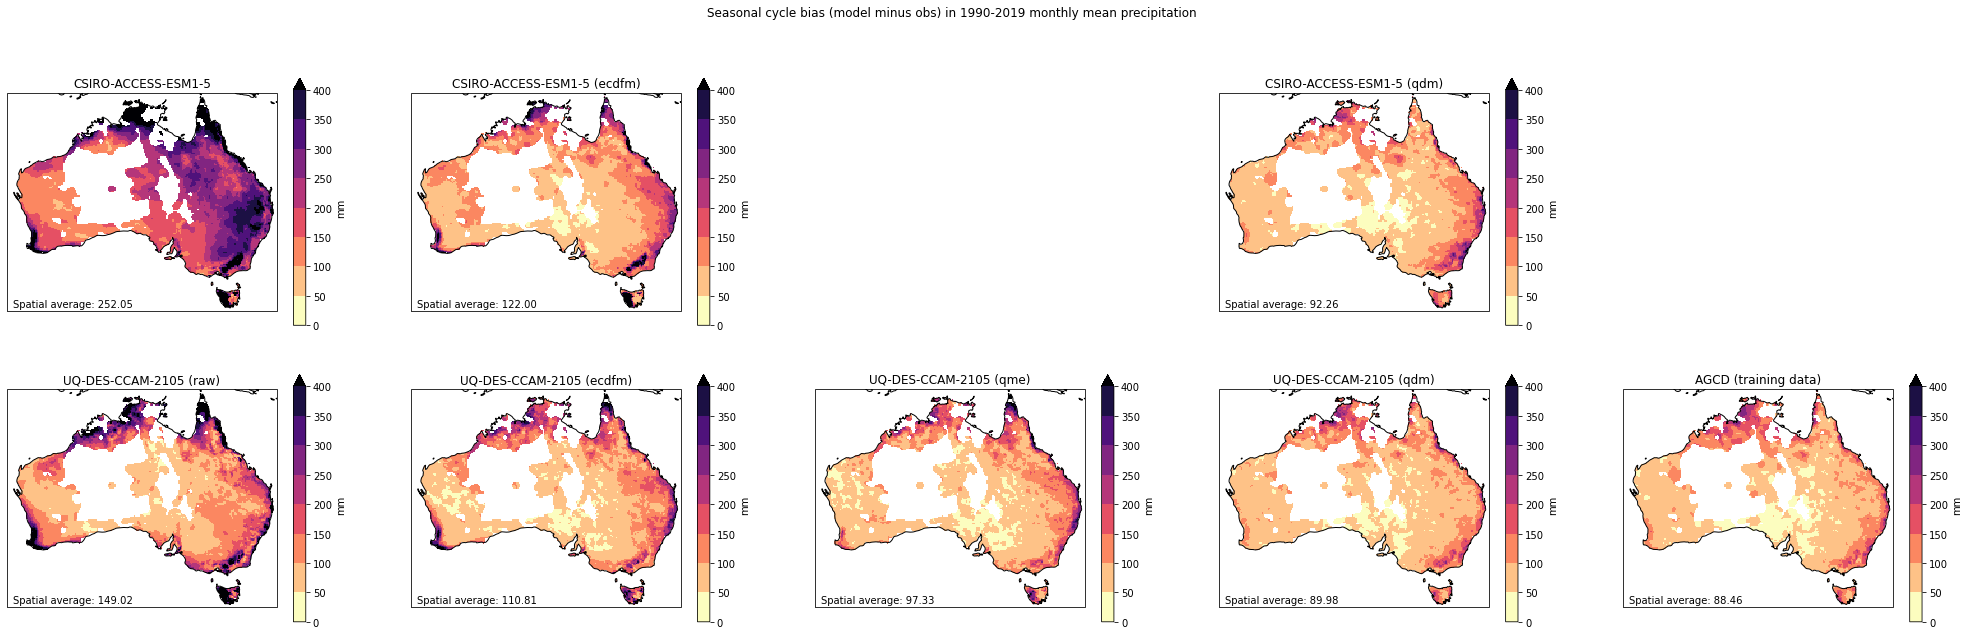

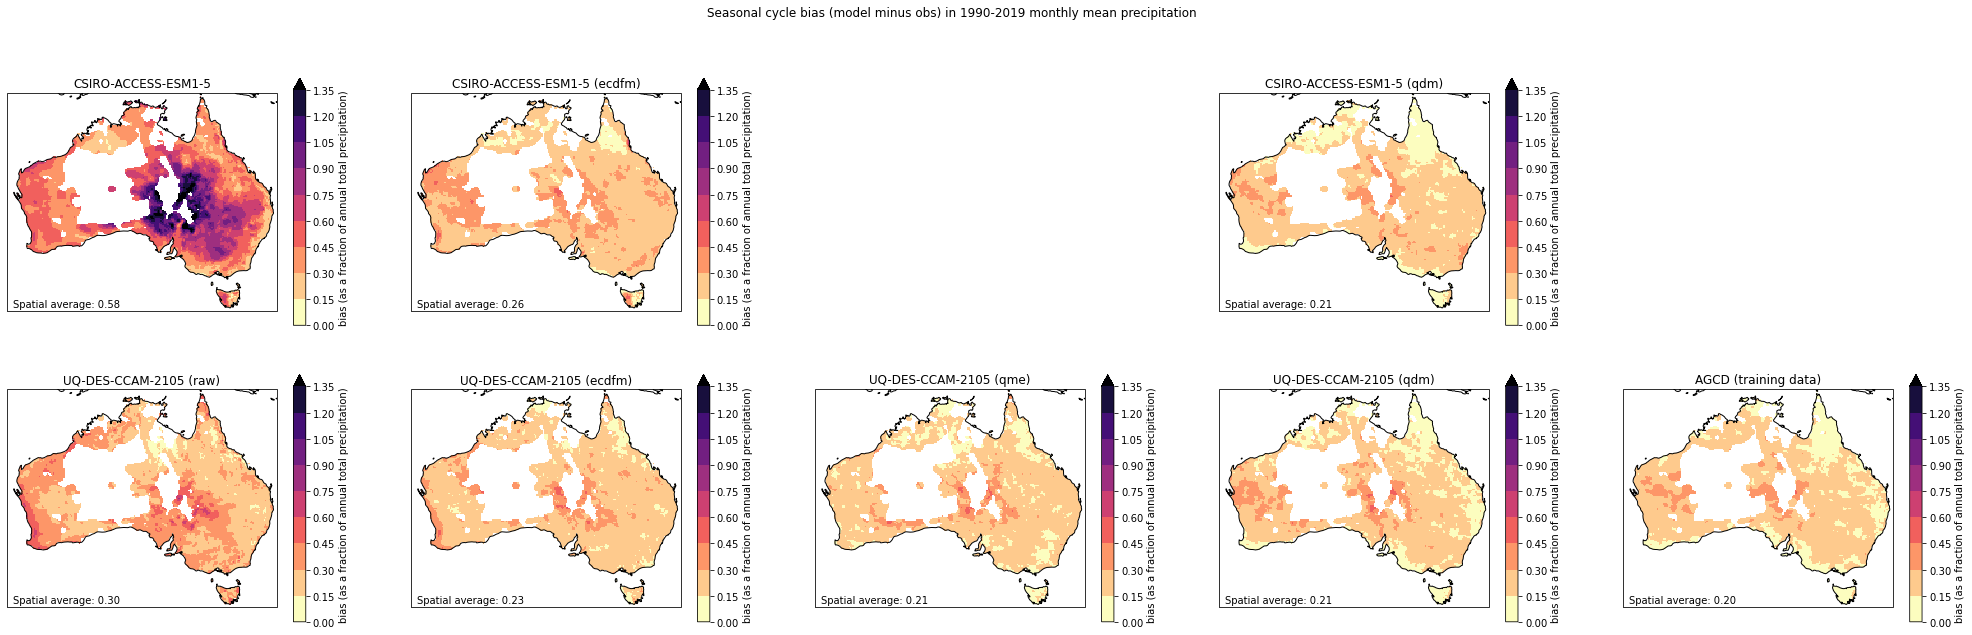

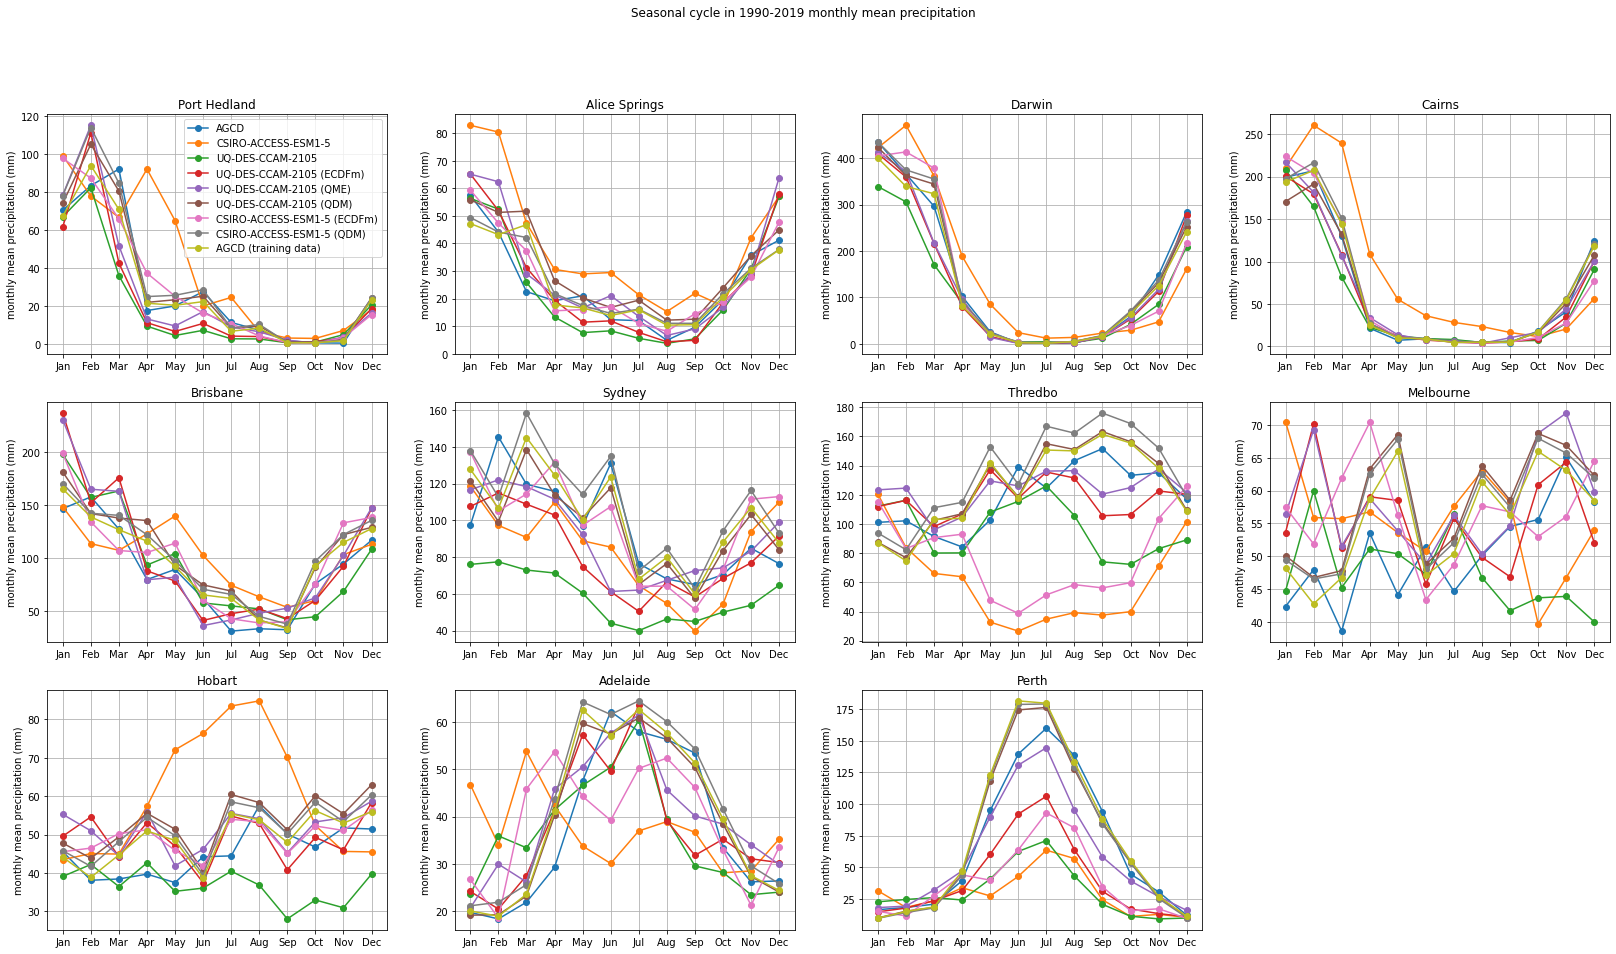

In [18]:
rcm = 'UQ-DES-CCAM-2105'
plot_rcm(
    da_obs, da_gcm, gcm_bc_dict, variable, gcm, rcm, task, start_date, end_date, da_training_obs, cities=True
)